**Цель ноутбука**: понять, где ошибается тяжеловесная модель alignn

In [1]:
import sys
sys.path.append('..')


import nglview
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.utils import read_json_structures, RootPath


plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 200
pd.set_option('display.float_format', lambda x: '%.5f' % x)

/Users/tomatoparetogmail.com/Desktop/idao_22/env/lib/python3.8/site-packages/pymatgen/core/__init__.py:51: UserWarning: Error loading .pmgrc.yaml: 'NoneType' object is not iterable. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [64]:
models = {
    'jv_optb88vdw_bandgap_alignn_train.json': 1,
    'mp_gappbe_alignnn_train.json': 2,
    'jv_mbj_bandgap_alignn_train.json': 3,
    'qm9_gap_alignn_train.json': 4
}

num_to_models = {value: key.strip('.json') for key, value in models.items()}

df = pd.read_csv(
    RootPath('predictions/train_predictions.csv', must_exist=True)
).rename(models, axis=1).set_index('id')

df = df.join(
pd.read_csv(RootPath('data/dichalcogenides_public/targets.csv')).rename({'_id': 'id'}, axis=1).set_index('id')
)
df.head()


jv_mbj_bandgap_alignn_pred_train_no_defects  \
id                                                                      
61420e2831cf3ef3d4a9f298                                      0.26280   
6141f75c4e27a1844a5f0498                                      1.43130   
6141f0a9ee0a3fd43fb47d83                                      1.43530   
614222d04e27a1844a5f0642                                      1.43377   
614204414e27a1844a5f0532                                      0.53431   

                          jv_optb88vdw_bandgap_alignn_pred_train_defects  \
id                                                                         
61420e2831cf3ef3d4a9f298                                         1.14485   
6141f75c4e27a1844a5f0498                                         0.40101   
6141f0a9ee0a3fd43fb47d83                                         0.41858   
614222d04e27a1844a5f0642                                         1.80491   
614204414e27a1844a5f0532                                         0.36655   

                          qm9_gap_alignn_pred_train_no_defects  \
id                                                               
61420e2831cf3ef3d4a9f298                               0.48328   
6141f75c4e27a1844a5f0498                               1.05945   
6141f0a9ee0a3fd43fb47d83                               1.06736   
614222d04e27a1844a5f0642                               1.06592   
614204414e27a1844a5f0532                               0.54011   

                          qm9_gap_alignn_pred_train_defects  \
id                                                            
61420e2831cf3ef3d4a9f298                            1.14355   
6141f75c4e27a1844a5f0498                            0.38984   
6141f0a9ee0a3fd43fb47d83                            0.42124   
614222d04e27a1844a5f0642                            1.79304   
614204414e27a1844a5f0532                            0.36875   

                          jv_optb88vdw_bandgap_alignn_pred_train_no_defects  \
id                                                                            
61420e2831cf3ef3d4a9f298                                            0.76301   
6141f75c4e27a1844a5f0498                                            0.85748   
6141f0a9ee0a3fd43fb47d83                                            0.85619   
614222d04e27a1844a5f0642                                            0.85749   
614204414e27a1844a5f0532                                            0.18971   

                          mp_gappbe_alignnn_pred_train_defects  \
id                                                               
61420e2831cf3ef3d4a9f298                               1.14483   
6141f75c4e27a1844a5f0498                               0.38671   
6141f0a9ee0a3fd43fb47d83                               0.41640   
614222d04e27a1844a5f0642                               1.79813   
614204414e27a1844a5f0532                               0.34629   

                          mp_gappbe_alignnn_pred_train_no_defects  \
id                                                                  
61420e2831cf3ef3d4a9f298                                  0.92452   
6141f75c4e27a1844a5f0498                                  1.46464   
6141f0a9ee0a3fd43fb47d83                                  1.44603   
614222d04e27a1844a5f0642                                  1.44516   
614204414e27a1844a5f0532                                  0.52005   

                          jv_mbj_bandgap_alignn_pred_train_defects  \
id                                                                   
61420e2831cf3ef3d4a9f298                                   1.14220   
6141f75c4e27a1844a5f0498                                   0.38268   
6141f0a9ee0a3fd43fb47d83                                   0.41460   
614222d04e27a1844a5f0642                                   1.80558   
614204414e27a1844a5f0532                                   0.35436   

                          megnet_defects  
id                                       

### Анализ остатков предсказания

Метрика качества с лб:
$$ \frac{1}{n}\sum_{i=1}^{n} \left[|\hat{y} - y | < 0.02 \right]$$
То есть мы хотим, чтобы отклонение по модулю от реального значения энергии было минимальным и не превышало $0.02$. 

Как выглядят модули остатков для разных датасетов?

In [51]:
residuals = df.subtract(df['band_gap'], axis=0).drop('band_gap', axis=1)
root_public_path = RootPath('data/dichalcogenides_public')
root_private_path = RootPath('data/dichalcogenides_private')

df_private = read_json_structures(root_private_path / 'structures')
df_public = read_json_structures(
    root_public_path / 'structures'
).merge(pd.read_csv(root_public_path / 'targets.csv'))


# понадобится дальше
df_public['formula'] = df_public['structure'].apply(lambda x: x.formula)
df_private['formula'] = df_private['structure'].apply(lambda x: x.formula)

public = pd.concat([df_public.set_index('_id'), (residuals)], axis=1)
show = lambda id_: nglview.show_pymatgen(public.loc[id_, 'structure'])
residuals.abs().describe()

2967it [00:18, 156.62it/s]
2966it [00:18, 158.35it/s]


jv_mbj_bandgap_alignn_pred_train_no_defects  \
count                                   2966.00000   
mean                                       0.46509   
std                                        0.27725   
min                                        0.00019   
25%                                        0.29405   
50%                                        0.41150   
75%                                        0.52996   
max                                        1.72629   

       jv_optb88vdw_bandgap_alignn_pred_train_defects  \
count                                      2966.00000   
mean                                          0.54363   
std                                           0.46828   
min                                           0.00002   
25%                                           0.04889   
50%                                           0.66463   
75%                                           0.77482   
max                                           1.62980   

       qm9_gap_alignn_pred_train_no_defects  \
count                            2966.00000   
mean                                0.47364   
std                                 0.29410   
min                                 0.00025   
25%                                 0.22327   
50%                                 0.48736   
75%                                 0.72321   
max                                 1.32741   

       qm9_gap_alignn_pred_train_defects  \
count                         2966.00000   
mean                             0.54432   
std                              0.46856   
min                              0.00002   
25%                              0.04965   
50%                              0.66436   
75%                              0.76738   
max                              1.59654   

       jv_optb88vdw_bandgap_alignn_pred_train_no_defects  \
count                                         2966.00000   
mean                                             0.52690   
std                                              0.46559   
min                                              0.00004   
25%                                              0.12834   
50%                                              0.42534   
75%                                              0.82643   
max                                              1.70878   

       mp_gappbe_alignnn_pred_train_defects  \
count                            2966.00000   
mean                                0.54700   
std                                 0.47225   
min                                 0.00003   
25%                                 0.04740   
50%                                 0.66815   
75%                                 0.78436   
max                                 1.61600   

       mp_gappbe_alignnn_pred_train_no_defects  \
count                               2966.00000   
mean                                   0.46212   
std                                    0.31585   
min                                    0.00187   
25%                                    0.26750   
50%                                    0.38708   
75%                                    0.55689   
max                                    1.46439   

       jv_mbj_bandgap_alignn_pred_train_defects  megnet_defects  
count                                2966.00000      2966.00000  
mean                                    0.54804         0.00715  
std                                     0.47355         0.02471  
min                                     0.00000         0.00000  
25%                                     0.04821         0.00156  
50%                                     0.67000         0.00327  
75%                                     0.78359         0.00694  
max                                     1.62676         0.65768

#### Анализ неправильных предсказаний

Какая модель ошибалась больше всего?

In [55]:
problematic_ids = residuals.where(residuals.abs() > 0.02).dropna(axis=0, how='all')
problematic_ids.count()

jv_mbj_bandgap_alignn_pred_train_no_defects          2909
jv_optb88vdw_bandgap_alignn_pred_train_defects       2513
qm9_gap_alignn_pred_train_no_defects                 2883
qm9_gap_alignn_pred_train_defects                    2556
jv_optb88vdw_bandgap_alignn_pred_train_no_defects    2864
mp_gappbe_alignnn_pred_train_defects                 2510
mp_gappbe_alignnn_pred_train_no_defects              2942
jv_mbj_bandgap_alignn_pred_train_defects             2518
megnet_defects                                        159
dtype: int64

**Вывод:** третья модель (jv_mbj_bandgap_alignn_train) допускает больше всего критических ошибок

Как распределены ошибки предсказаний для каждой из модели?

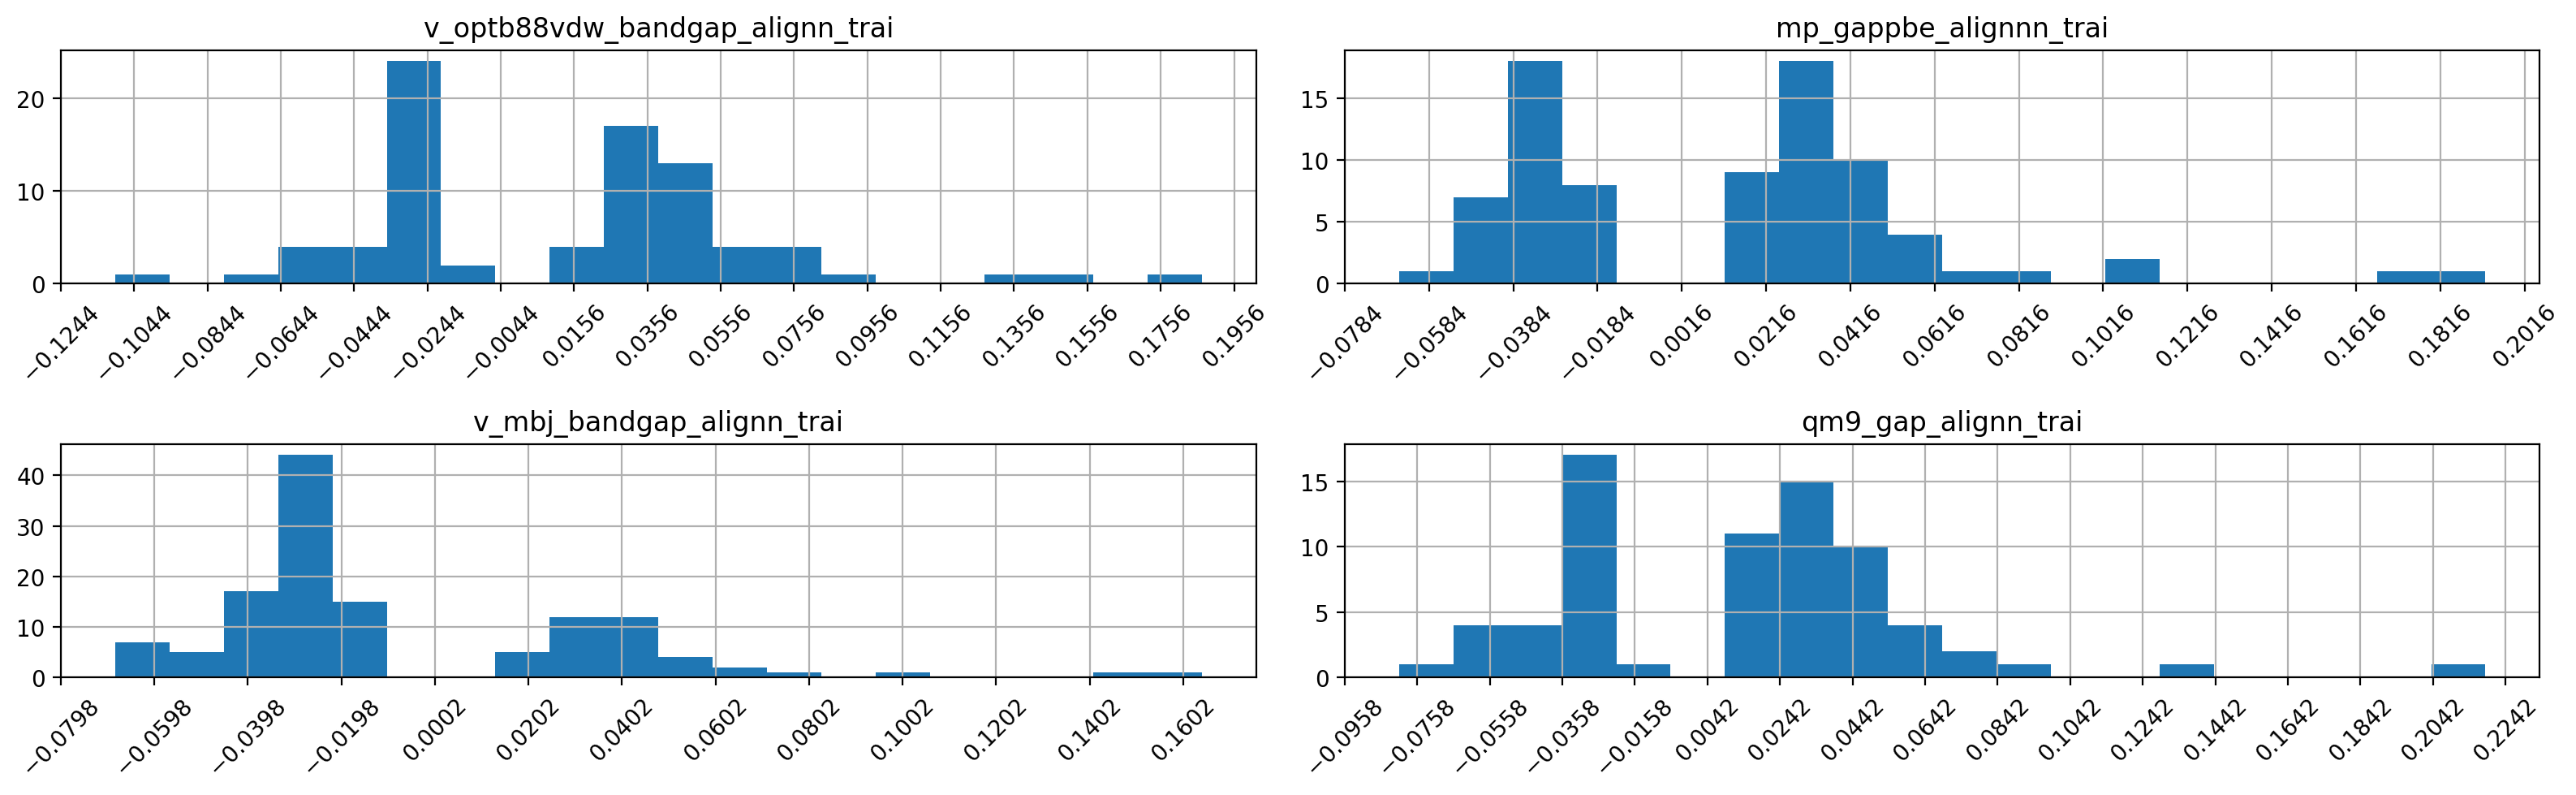

In [5]:
hist_stepsize = 0.02
axes_row = problematic_ids.hist(bins=20, xrot=45, grid=True, layout=(2, 2))

for row in axes_row:
    for ax in row:
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, hist_stepsize))
        ax.set_title(num_to_models[int(ax.axes.title.get_text())])

plt.tight_layout()


Сколько было случаев, когда одновременно ошибалось 4, 3, 2 и 1 модель одновременно?

In [6]:
problematic_ids.count(axis=1).value_counts().sort_index(ascending=False)

4    40
3    30
2    28
1    56
dtype: int64

Как предикшены соотносятся с реальными данными в разрезе по моделям?

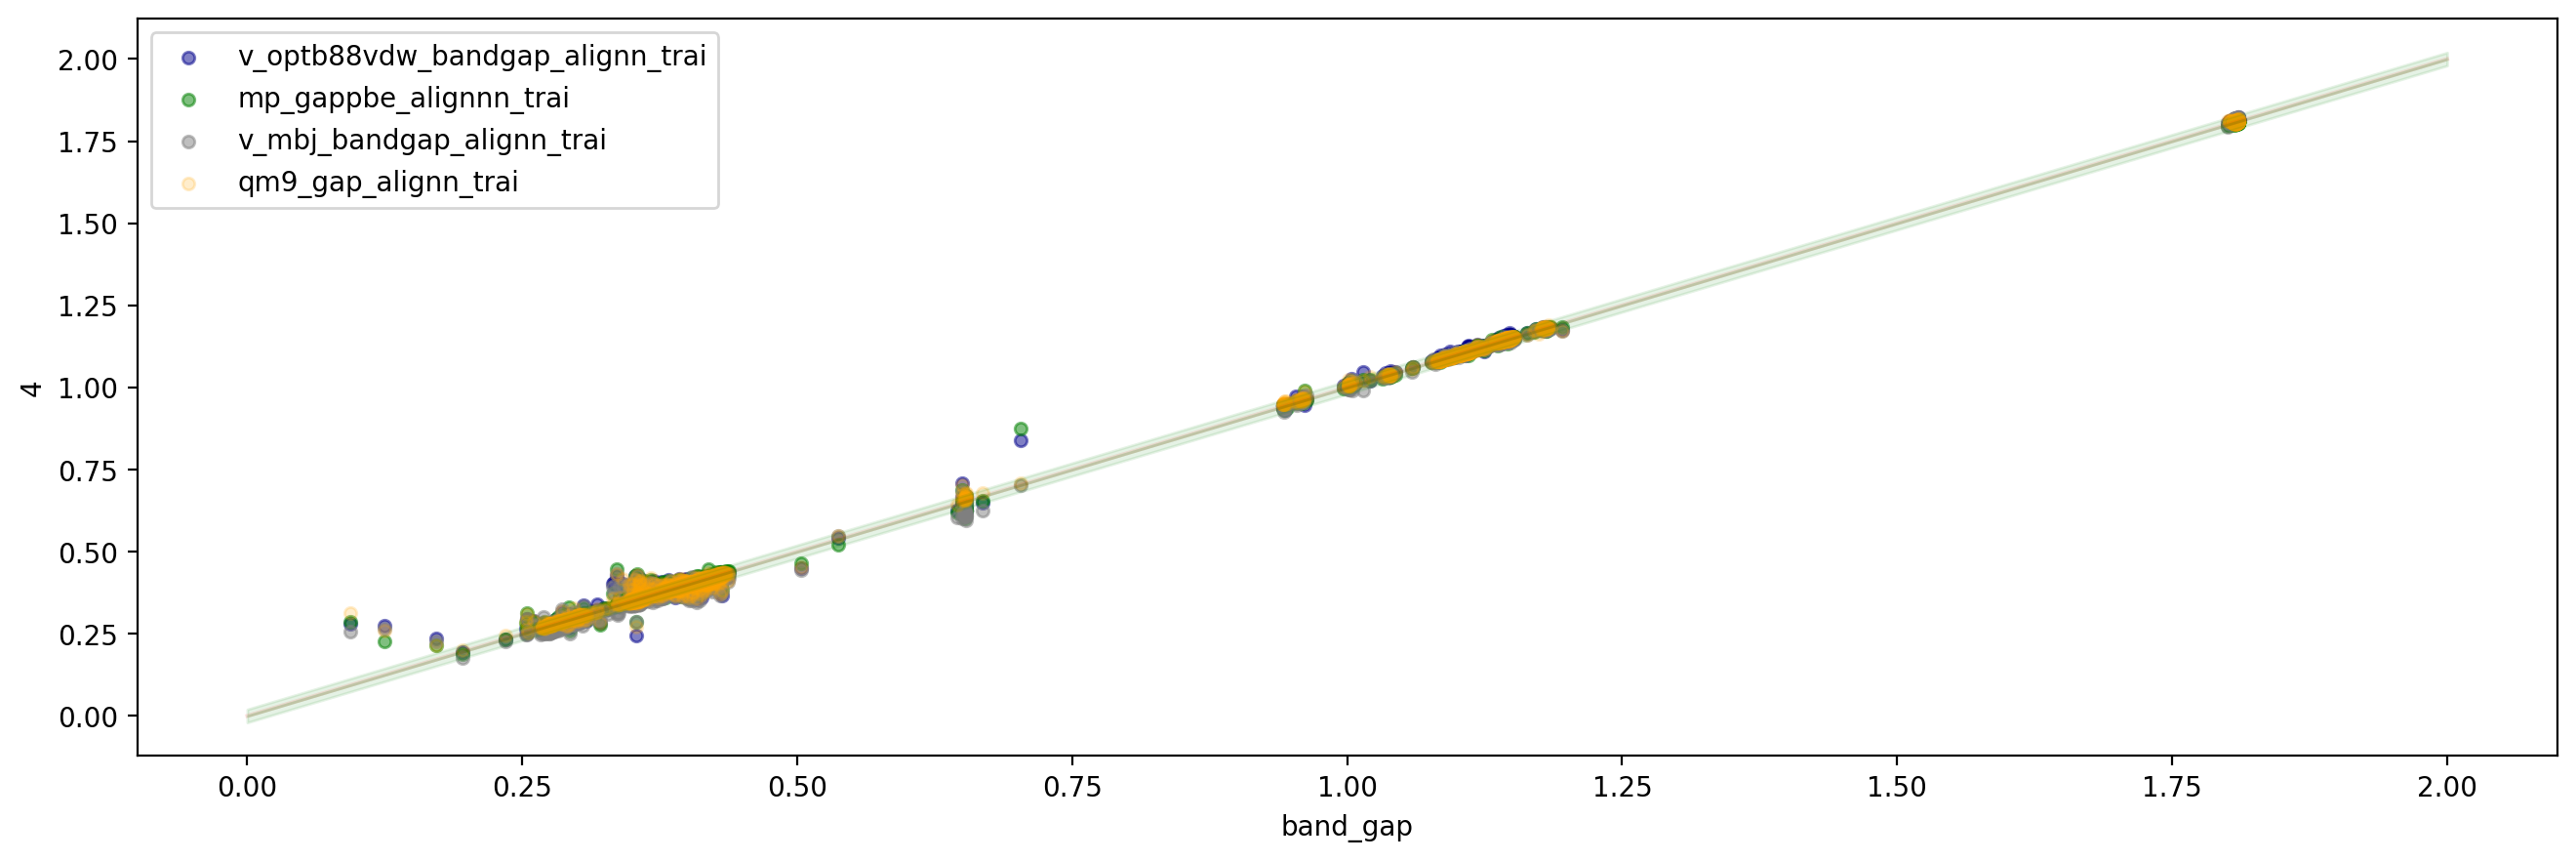

In [148]:
ax = df.plot(kind='scatter', x='band_gap', y=1, label=num_to_models[1], color='DarkBlue', alpha=0.5)
ax.plot([0,2], [0,2], color='red', alpha=0.1, label='IDEAL');
df.plot(kind='scatter', x='band_gap', y=2, label=num_to_models[2], ax=ax, color='green', alpha=0.5)
df.plot(kind='scatter', x='band_gap', y=3, label=num_to_models[3], ax=ax, color='grey', alpha=0.5)
df.plot(kind='scatter', x='band_gap', y=4, label=num_to_models[4], ax=ax, color='orange', alpha=0.2);
ax.fill_between([0, 2], [0, 2.0], [0.02, 2.02], alpha=0.1, color='green')
ax.fill_between([0, 2], [0, 2.0], [-0.02, 1.98], alpha=0.1, color='green');

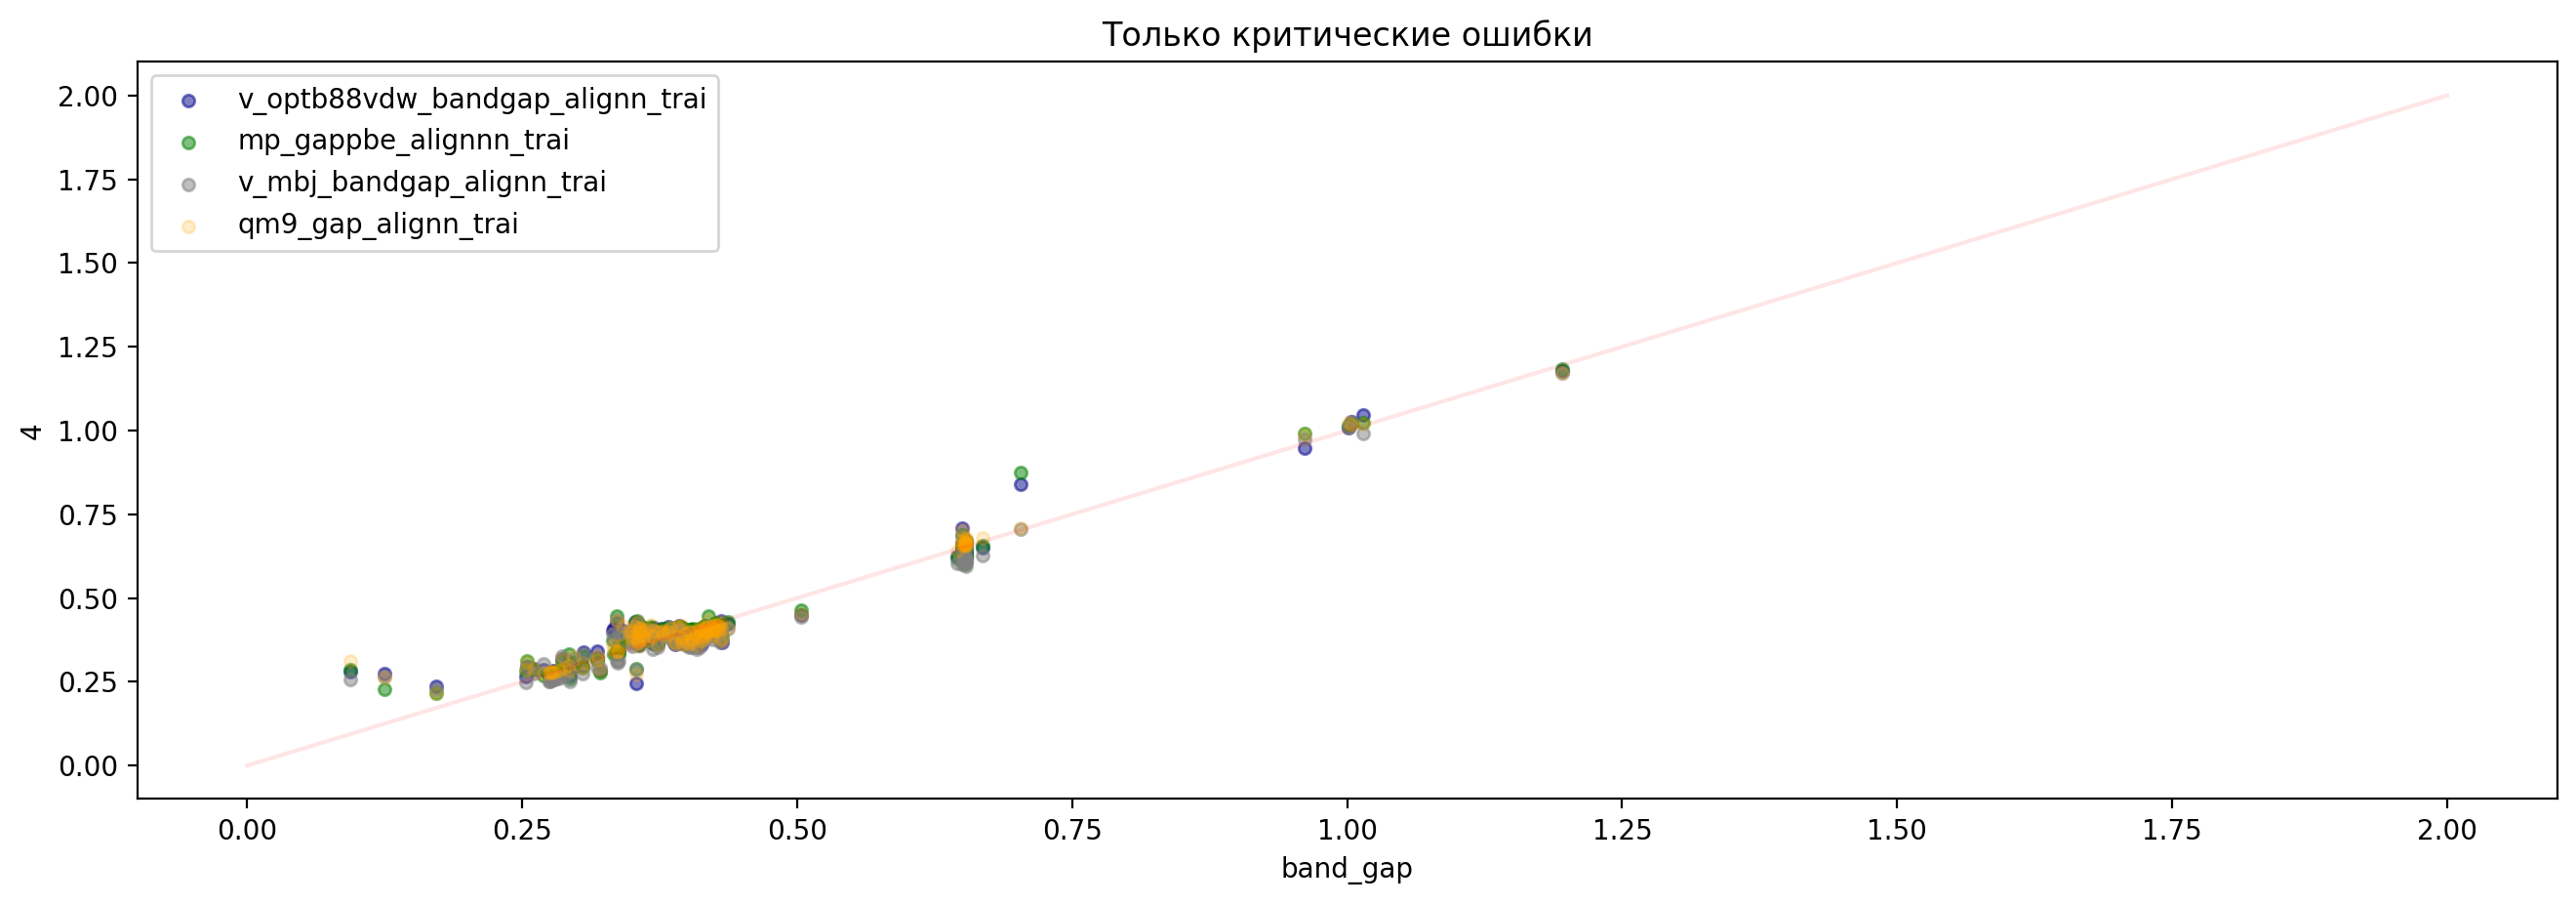

In [154]:
temp_ = df.loc[problematic_ids.index, :]
ax = temp_.plot(kind='scatter', x='band_gap', y=1, label=num_to_models[1], color='DarkBlue', alpha=0.5)
ax.plot([0,2], [0,2], color='red', alpha=0.1, label='IDEAL');
ax.set_title('Только критические ошибки')
temp_.plot(kind='scatter', x='band_gap', y=2, label=num_to_models[2], ax=ax, color='green', alpha=0.5)
temp_.plot(kind='scatter', x='band_gap', y=3, label=num_to_models[3], ax=ax, color='grey', alpha=0.5)
temp_.plot(kind='scatter', x='band_gap', y=4, label=num_to_models[4], ax=ax, color='orange', alpha=0.2);

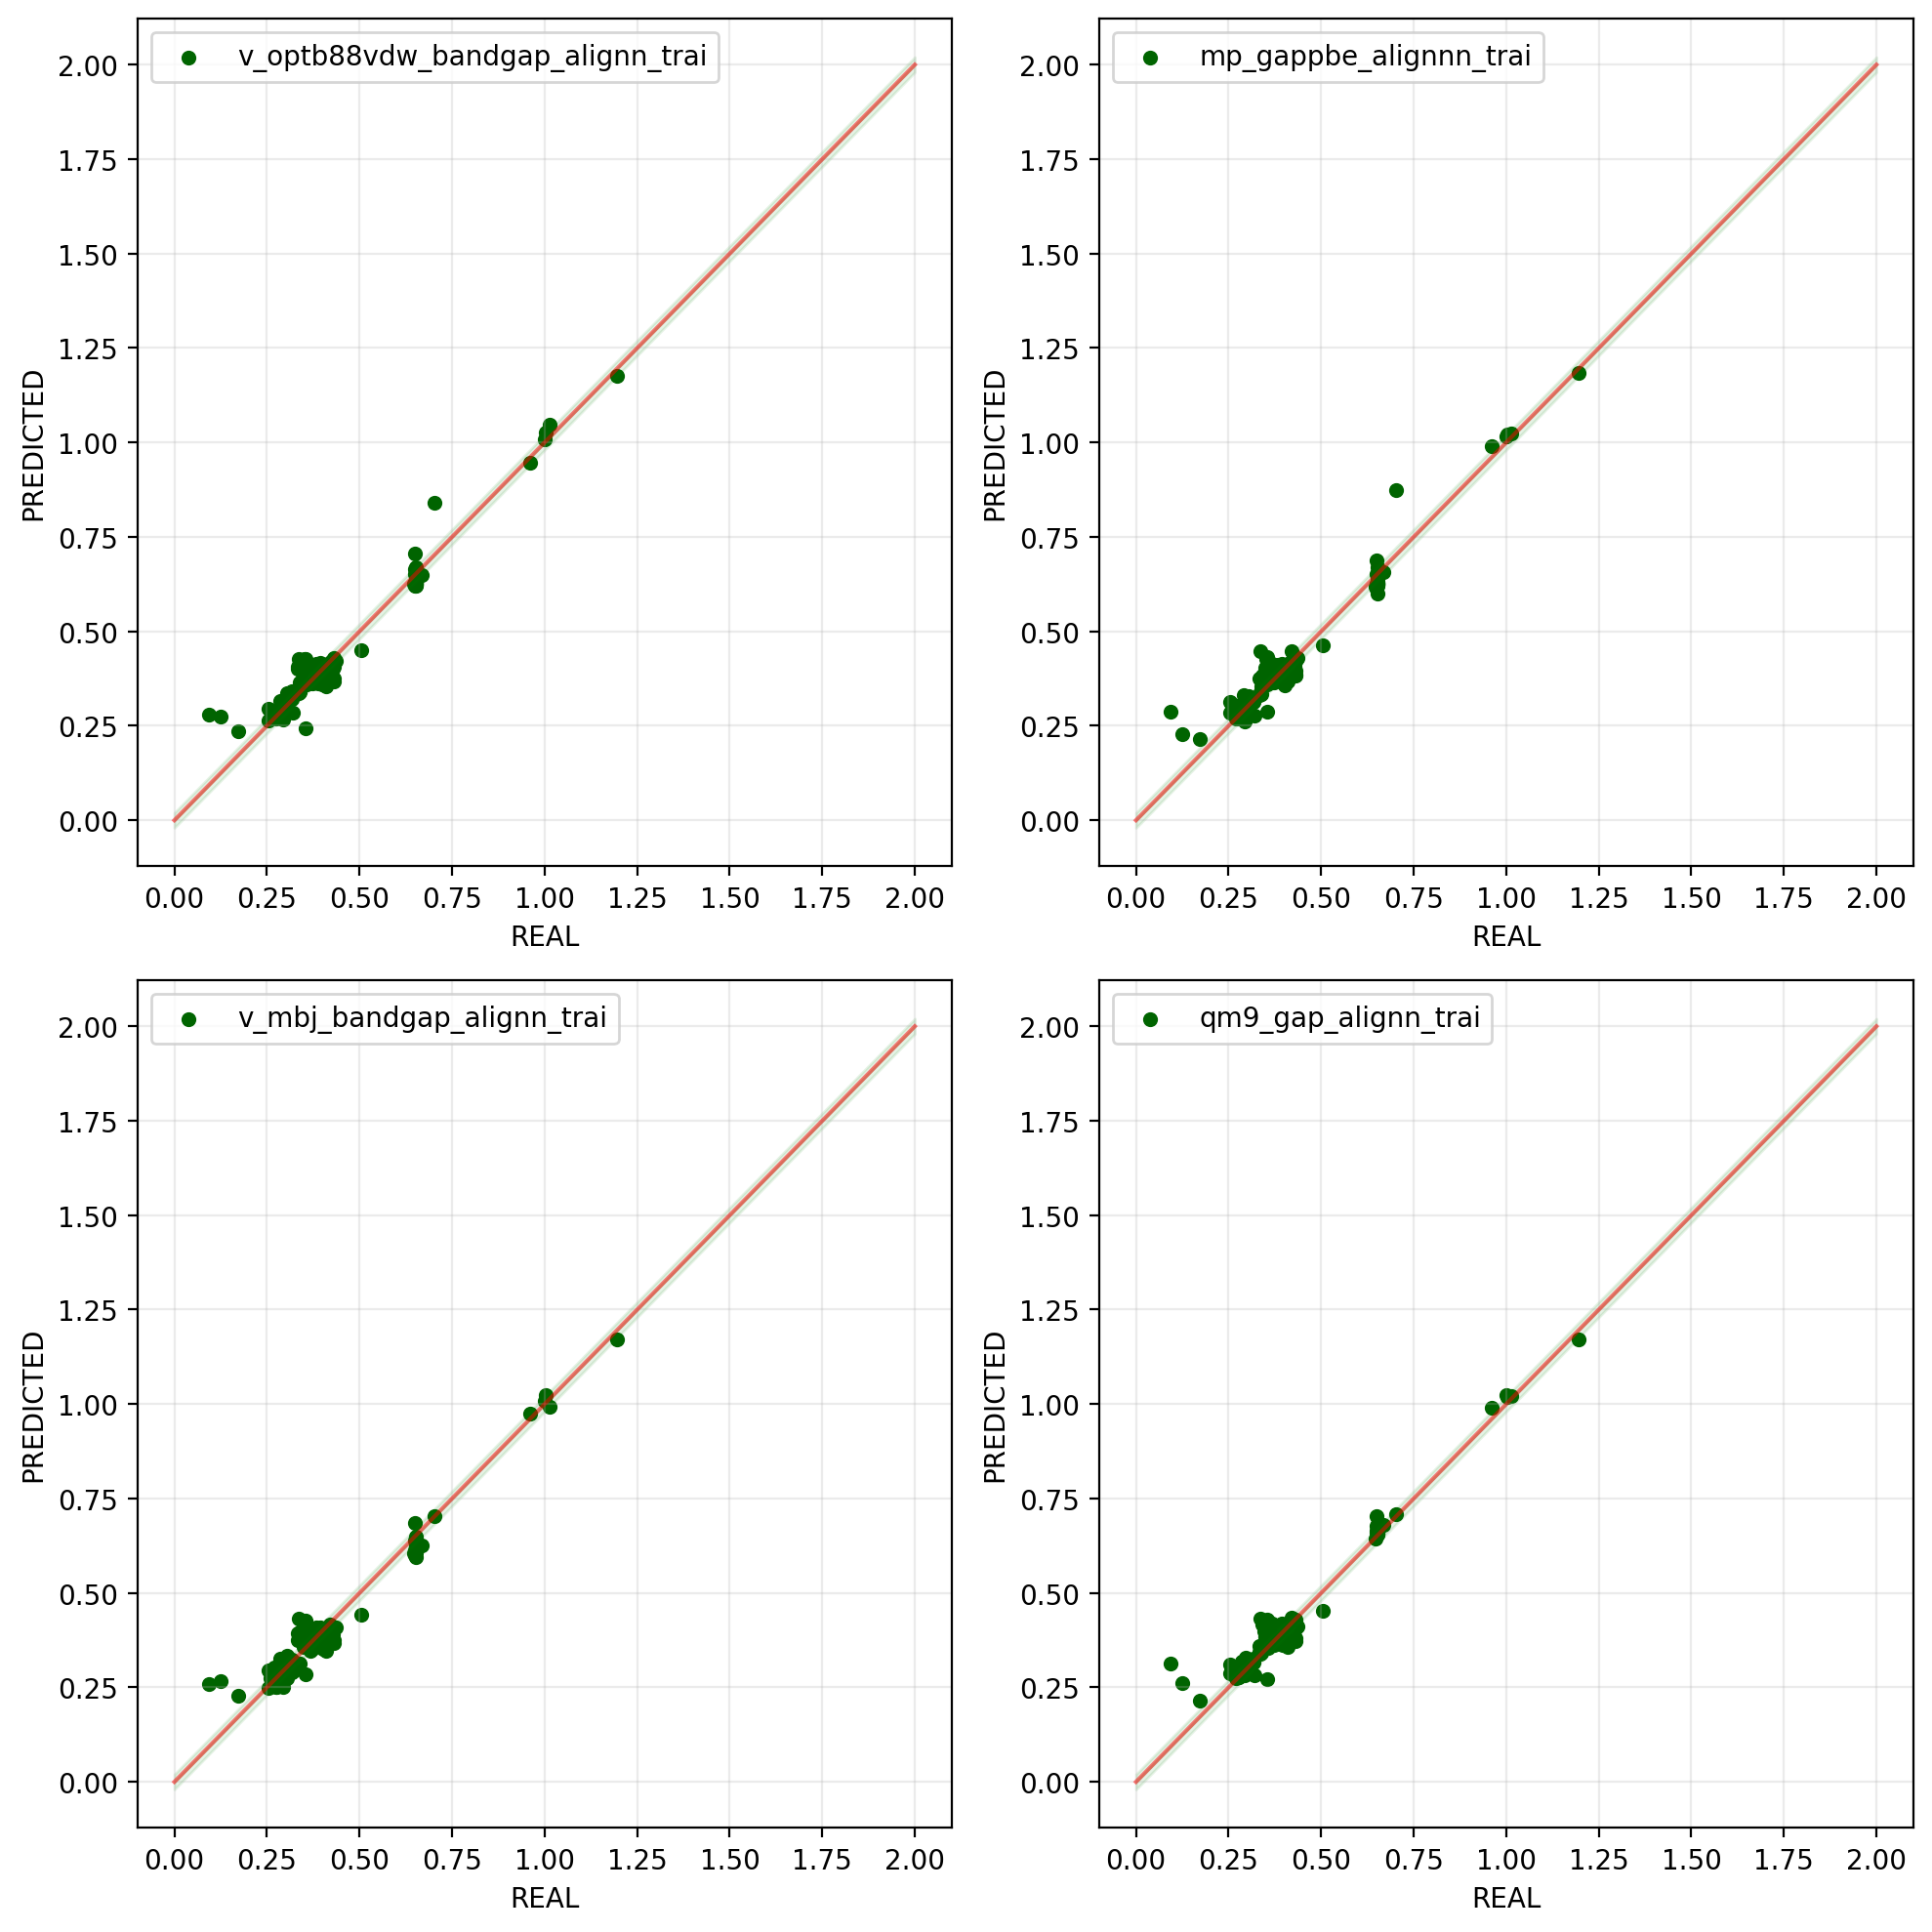

In [158]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
i = 1

for row in ax:
    for col in row:
        temp_.plot(kind='scatter', x='band_gap', y=i, label=num_to_models[i], xlabel='REAL',
                ylabel='PREDICTED', ax=col, grid=0.2, color='DarkGreen')
        col.plot([0,2],[0,2], color='red', alpha=0.5, label='IDEAL');
        i += 1
        col.fill_between([0, 2], [0, 2.0], [0.02, 2.02], alpha=0.1, color='green')
        col.fill_between([0, 2], [0, 2.0], [-0.02, 1.98], alpha=0.1, color='green');
        col.grid(alpha=0.25)
plt.tight_layout()

На какой энергии ошибки слишком большие?

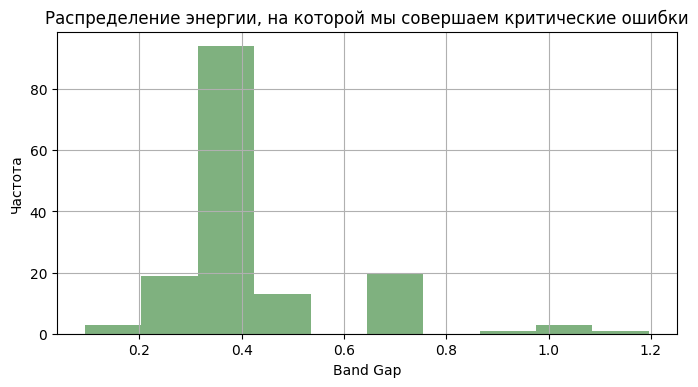

In [140]:
# какая энергия вызывает затруднения?
f, ax = plt.subplots(figsize=(8, 4), dpi=100)
public.loc[problematic_ids.index, :]['band_gap'].hist(ax=ax, color='DarkGreen', alpha=0.5);
ax.set_title('Распределение энергии, на которой мы совершаем критические ошибки')
ax.set_xlabel('Band Gap')
ax.set_ylabel('Частота');

Проблемные материалы в разбиении по формулам:

In [30]:
all_counts = public.value_counts('formula')
problematic_counts = public.loc[problematic_ids.index, :].value_counts('formula')

pd.concat([all_counts.rename('overall'), problematic_counts.rename('errors')], axis=1).fillna(0).astype(int)

overall  errors
formula                          
Mo63 W1 Se1 S126      716       1
Mo63 Se1 S126         702      58
Mo63 W1 S126          380      23
Mo63 Se2 S126         377      29
Mo63 S126             363      40
Mo63 W1 Se2 S126      360       0
Mo64 Se1 S126          18       0
Mo64 S126              12       1
Mo63 S127               8       1
Mo63 W1 S127            8       0
Mo64 Se2 S126           8       0
Mo63 Se1 S127           7       1
Mo63 W1 Se1 S127        5       0
Mo63 S128               1       0
Mo63 W1 S128            1       0

### Ошибки в рамках каждой из формул

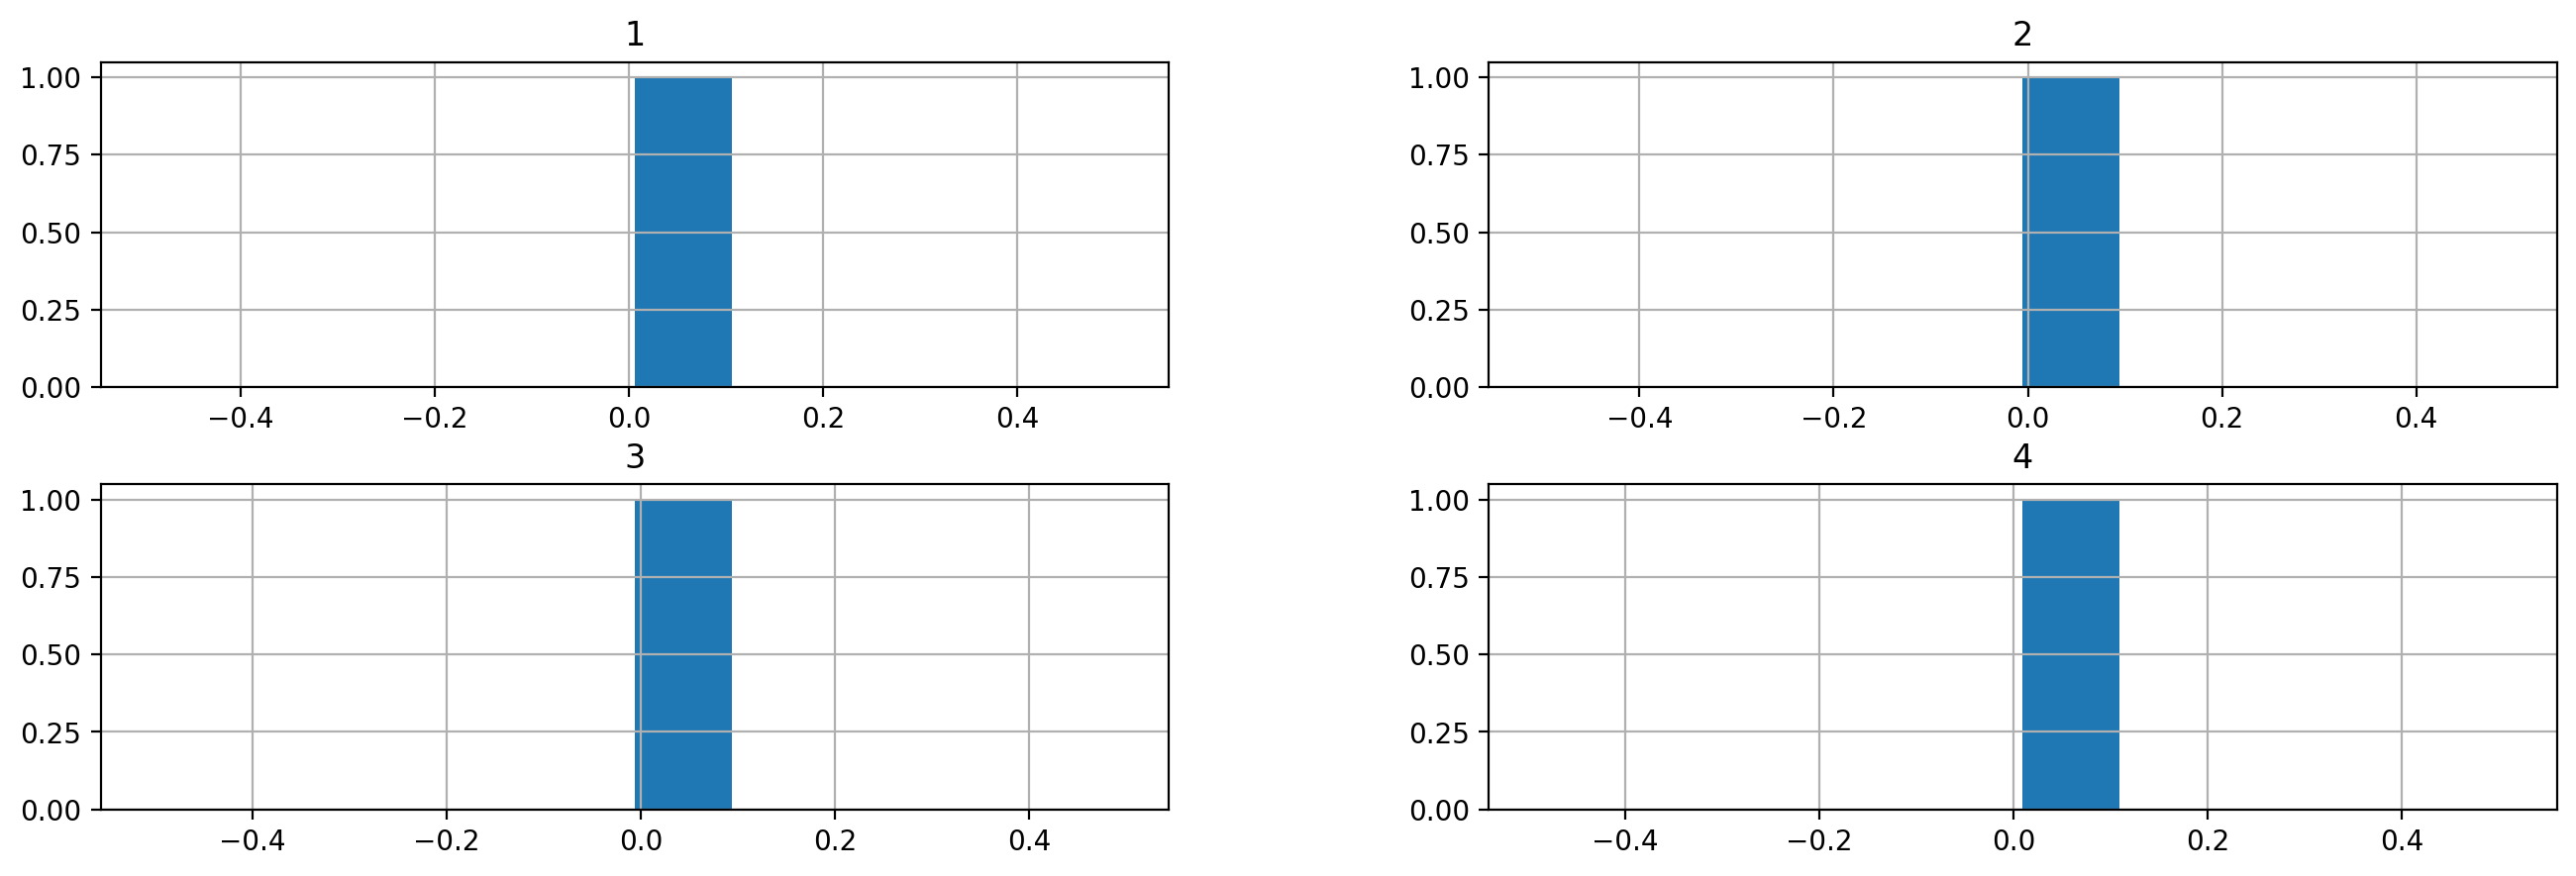

In [71]:
# Mo63 W1 S128	1	0
public[public['formula'] == 'Mo63 W1 S128'].iloc[:, -4:].hist();

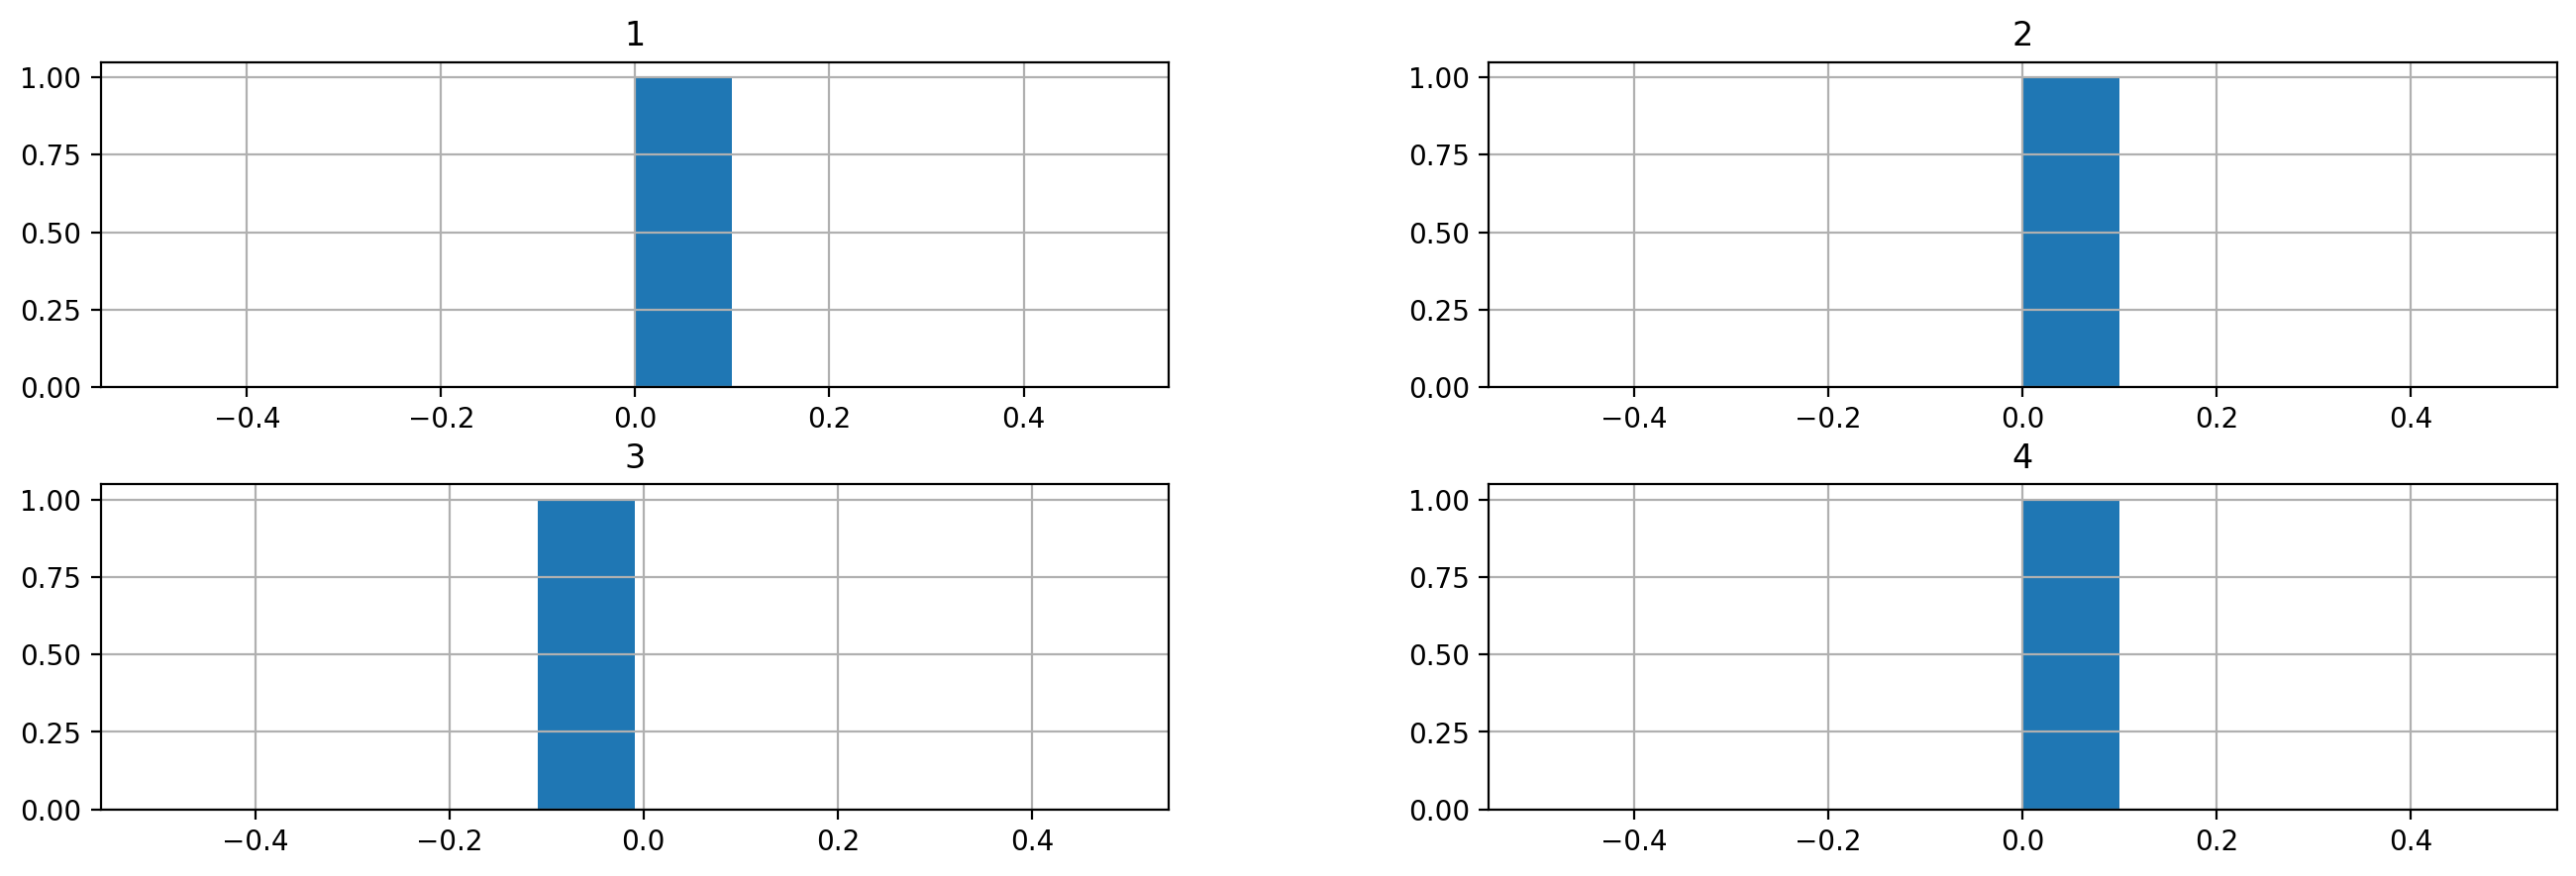

In [72]:
# Mo63 S128	1	0
public[public['formula'] == 'Mo63 S128'].iloc[:, -4:].hist();

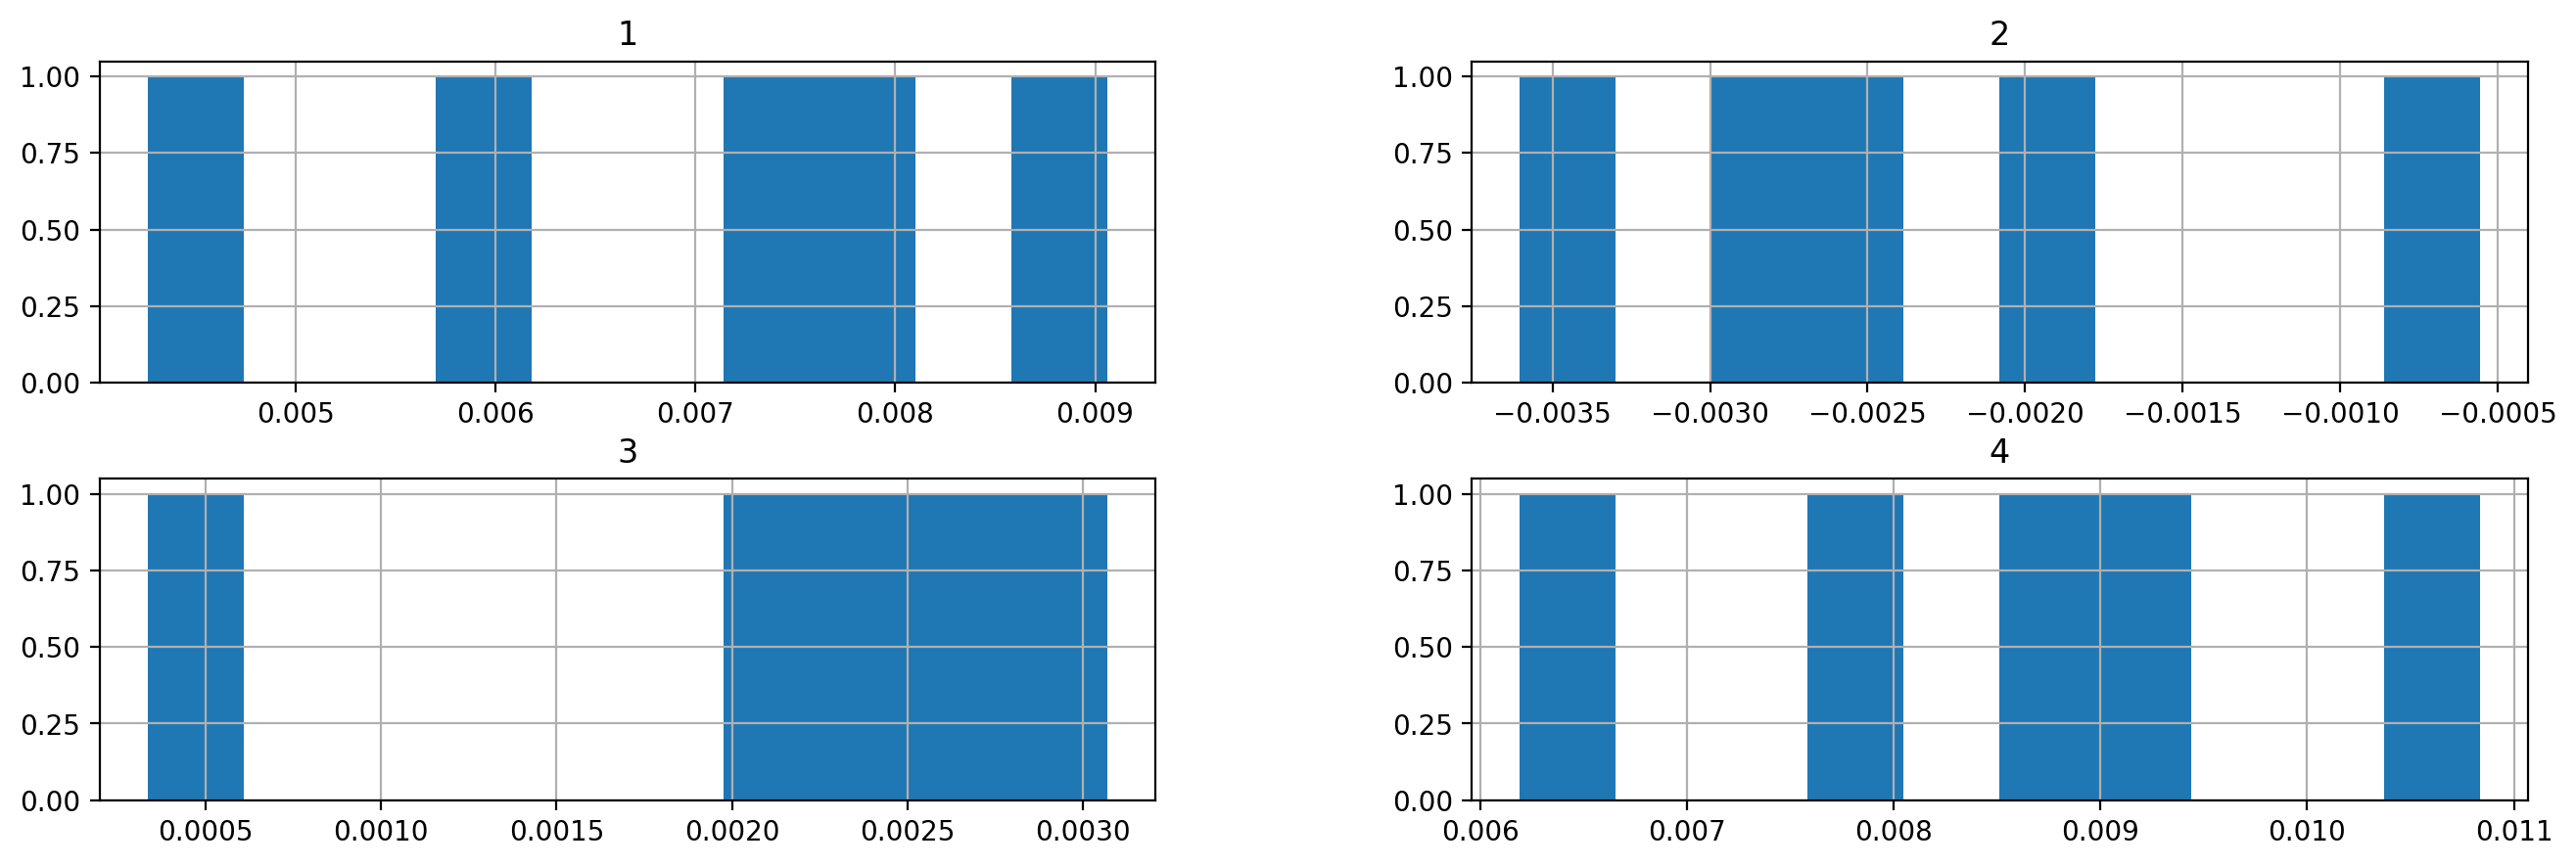

In [73]:
# Mo63 W1 Se1 S127	5	0
public[public['formula'] == 'Mo63 W1 Se1 S127'].iloc[:, -4:].hist();

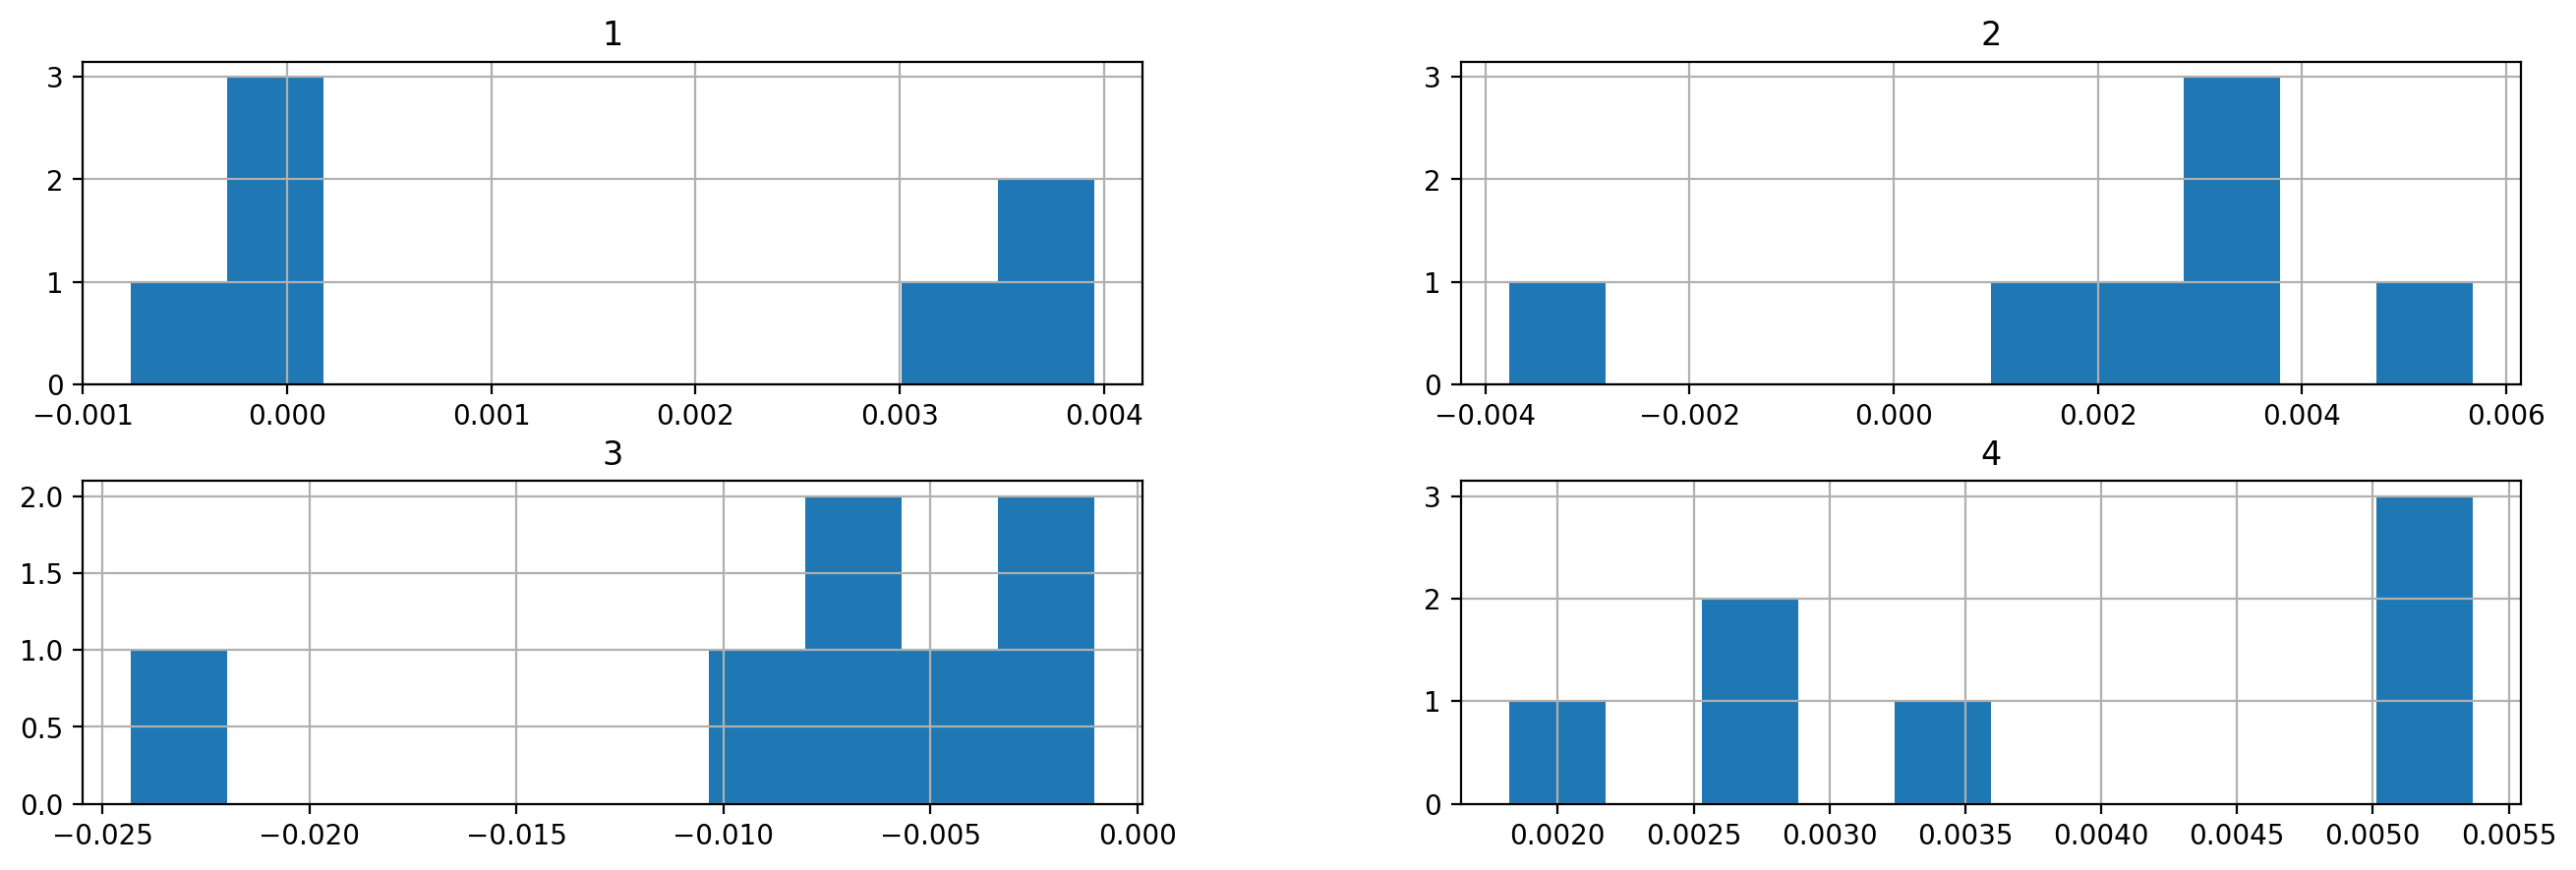

In [74]:
# Mo63 Se1 S127	7	1
public[public['formula'] == 'Mo63 Se1 S127'].iloc[:, -4:].hist();

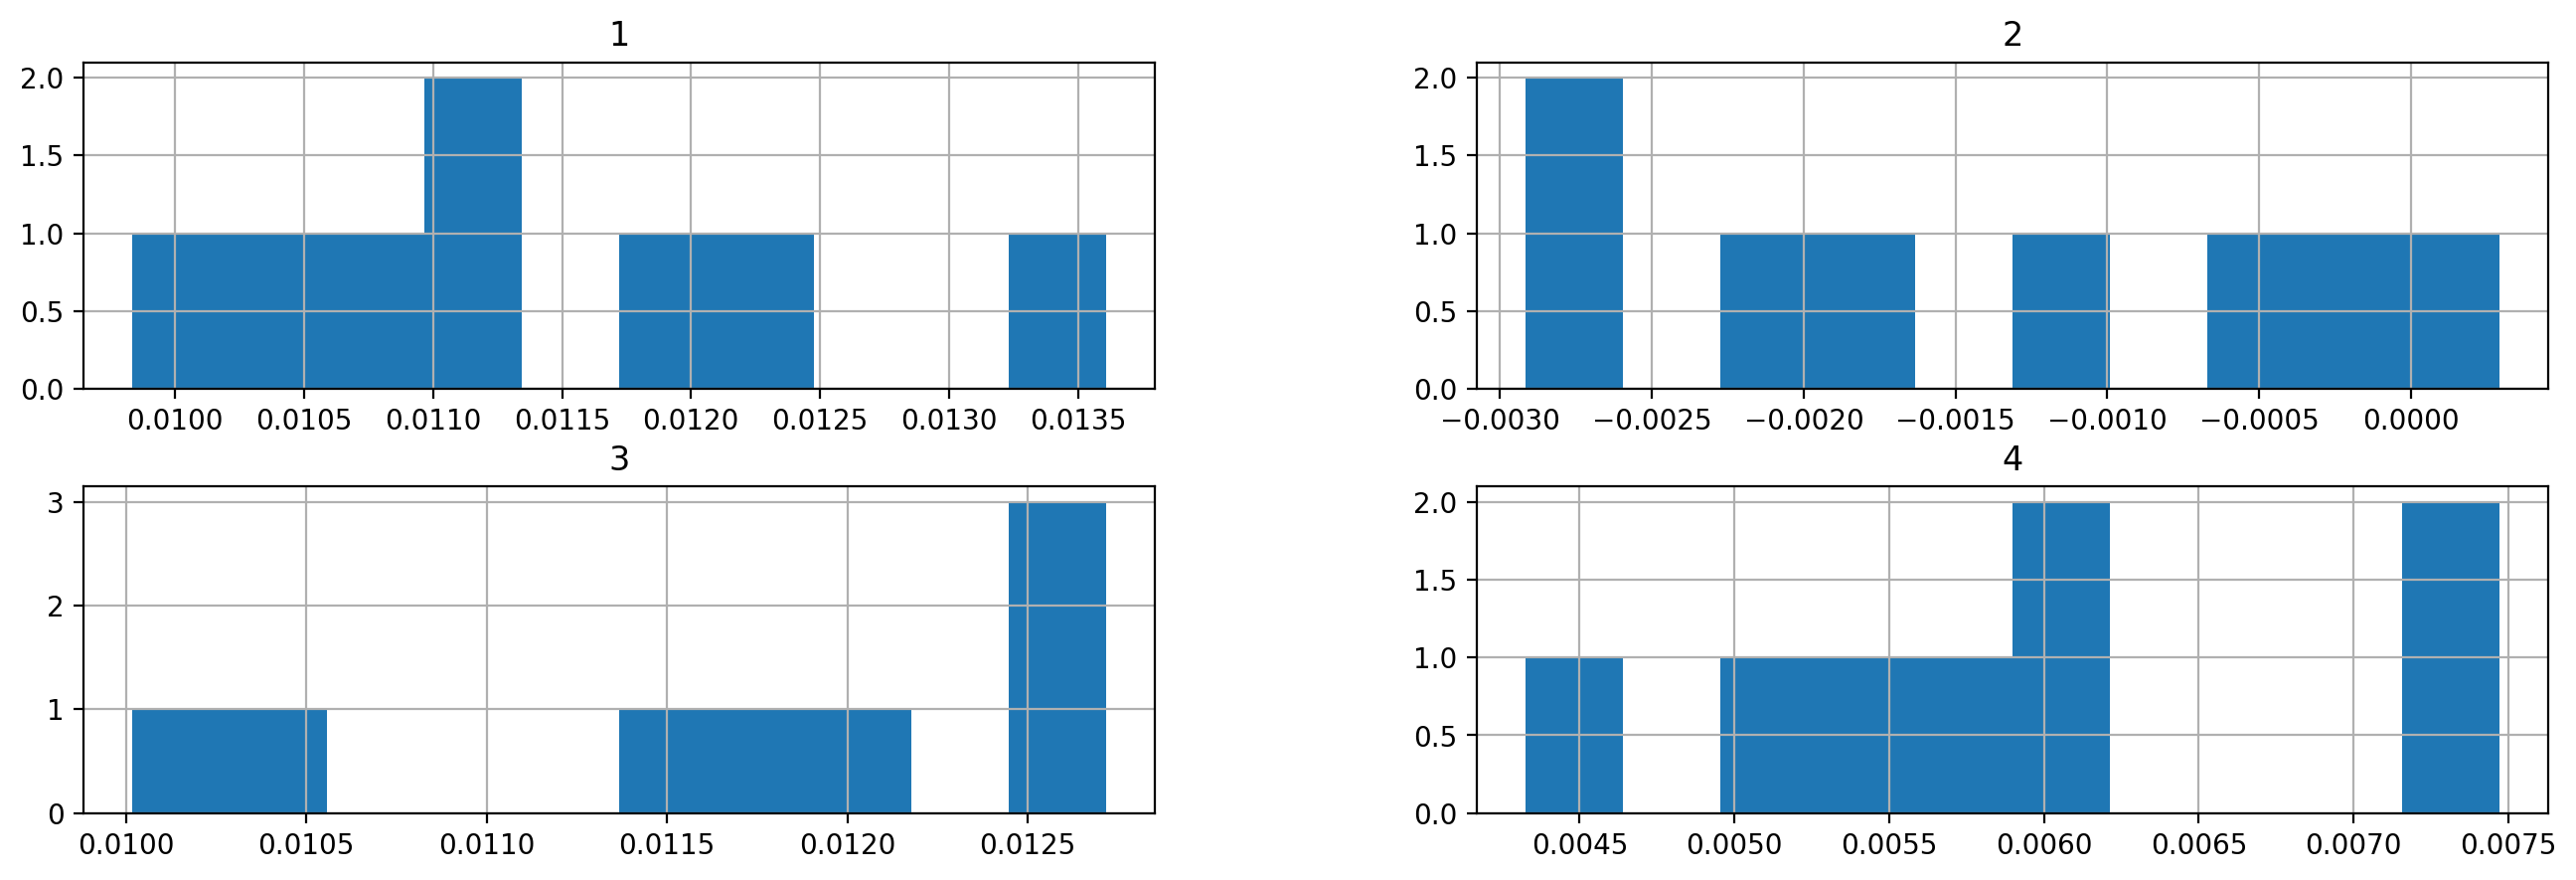

In [75]:
# Mo64 Se2 S126	8	0
public[public['formula'] == 'Mo64 Se2 S126'].iloc[:, -4:].hist();

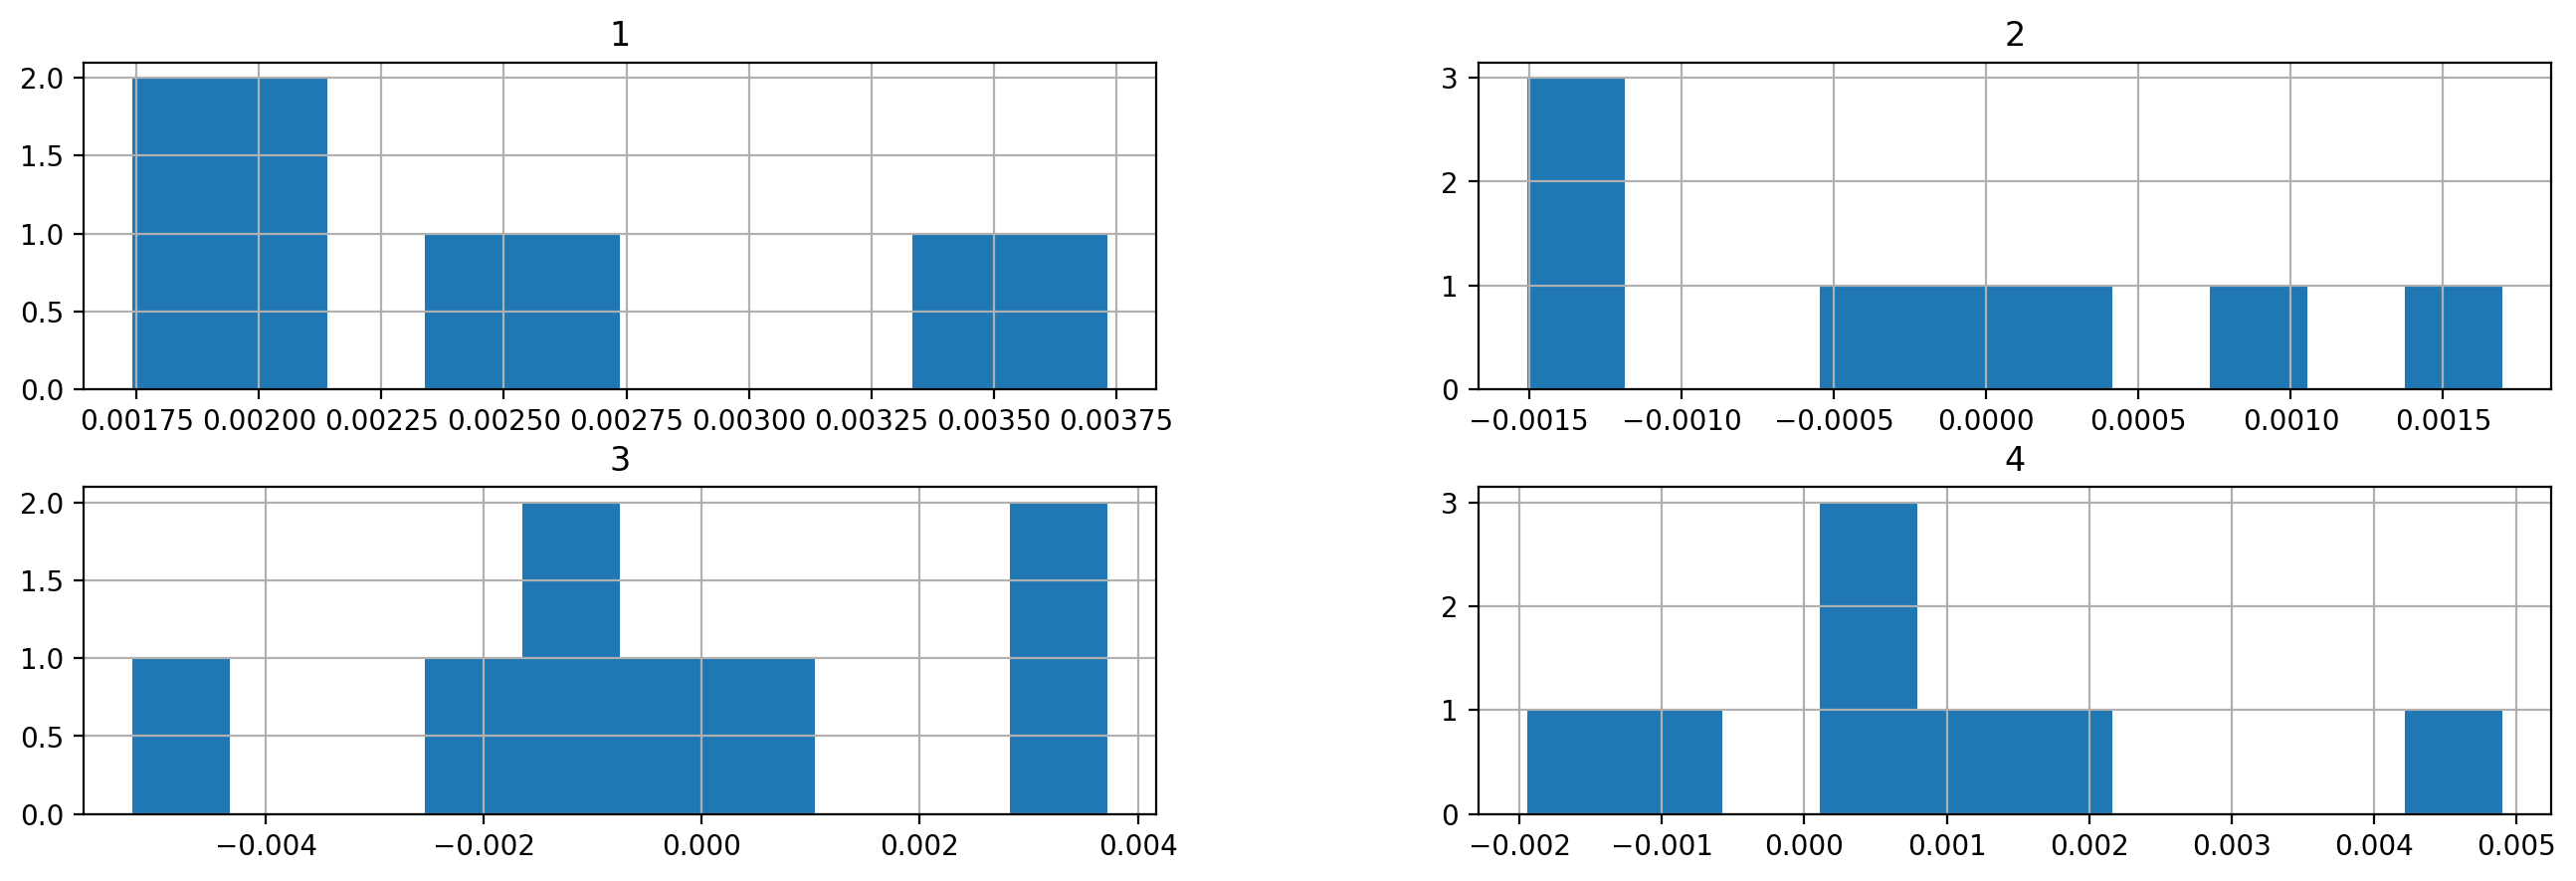

In [70]:
# Mo63 W1 S127	8	0
public[public['formula'] == 'Mo63 W1 S127'].iloc[:, -4:].hist();

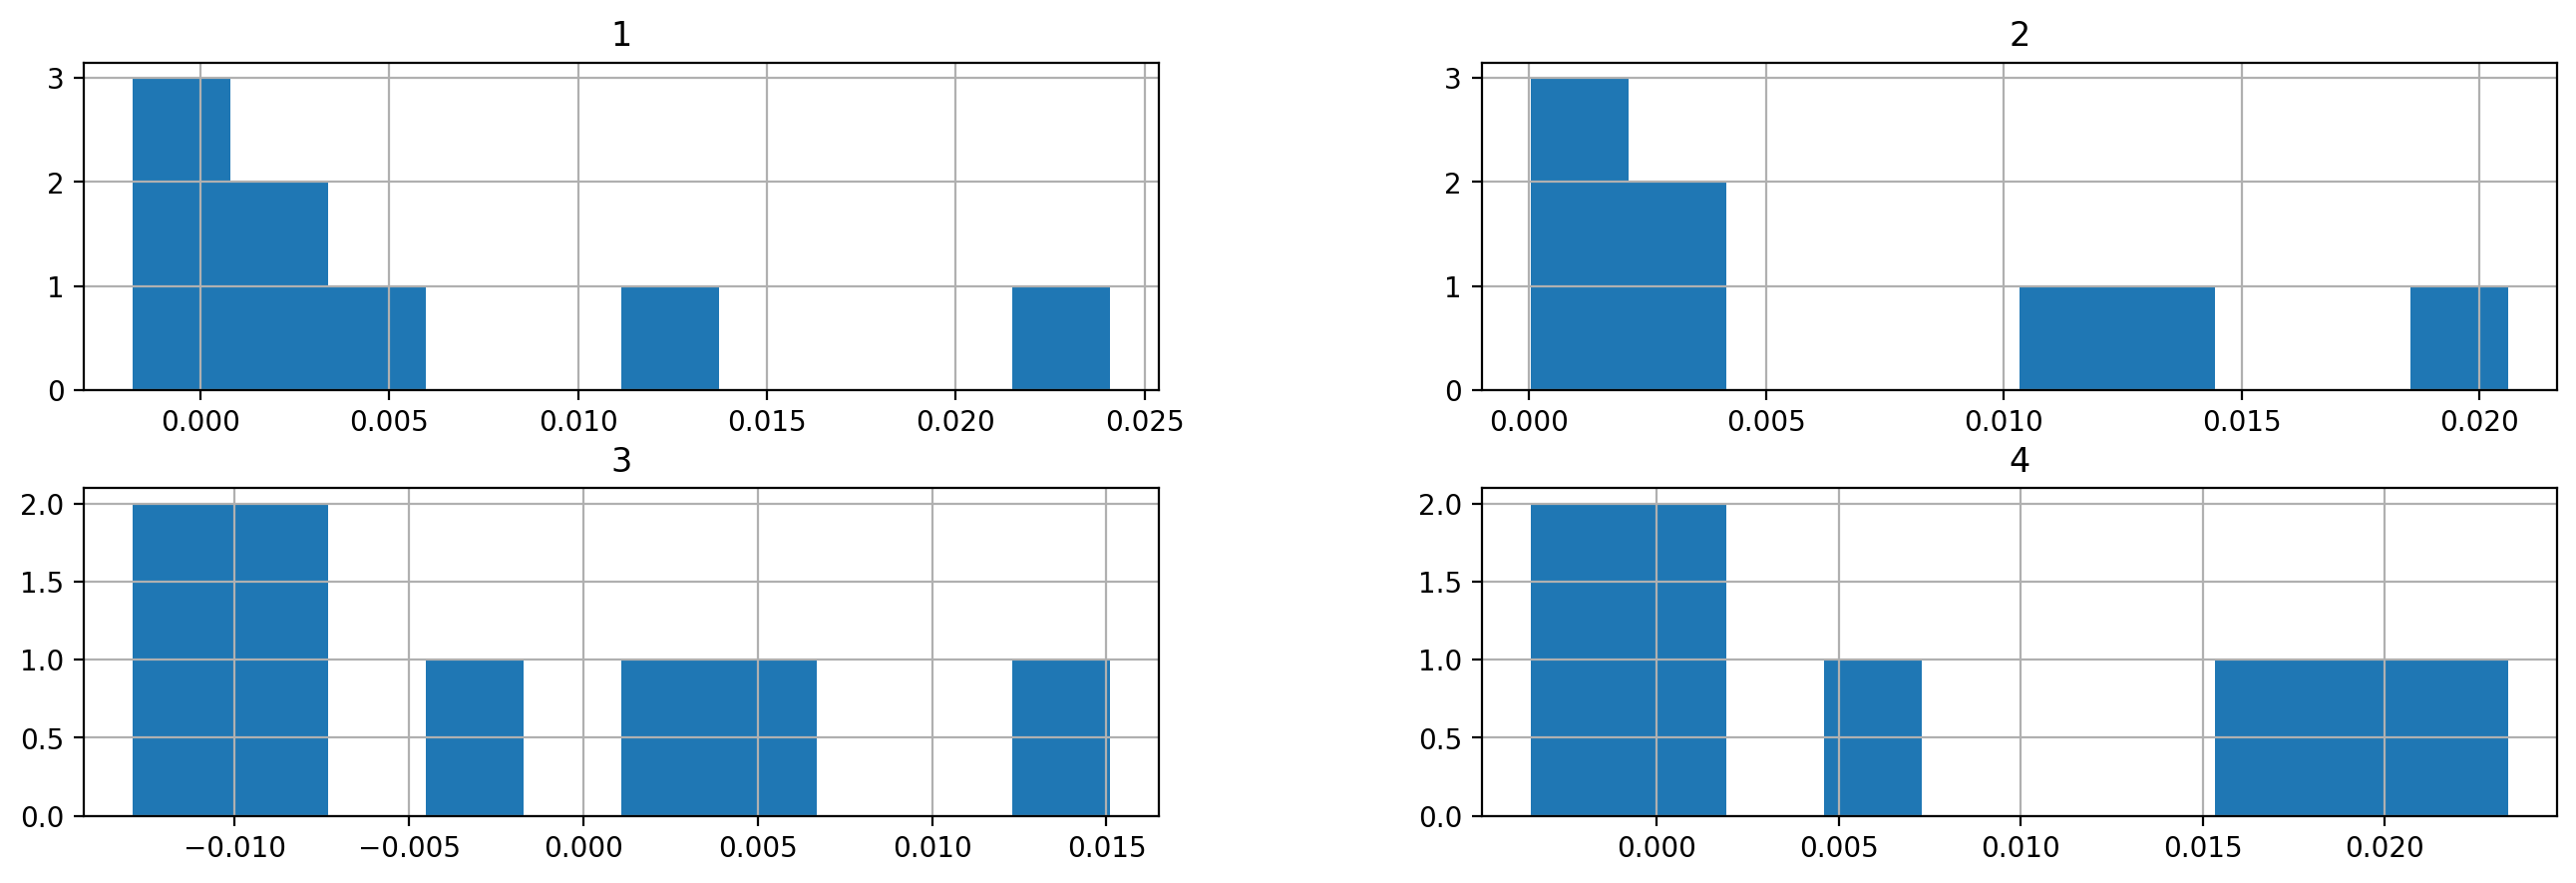

In [69]:
# Mo63 S127	8	1
public[public['formula'] == 'Mo63 S127'].iloc[:, -4:].hist();

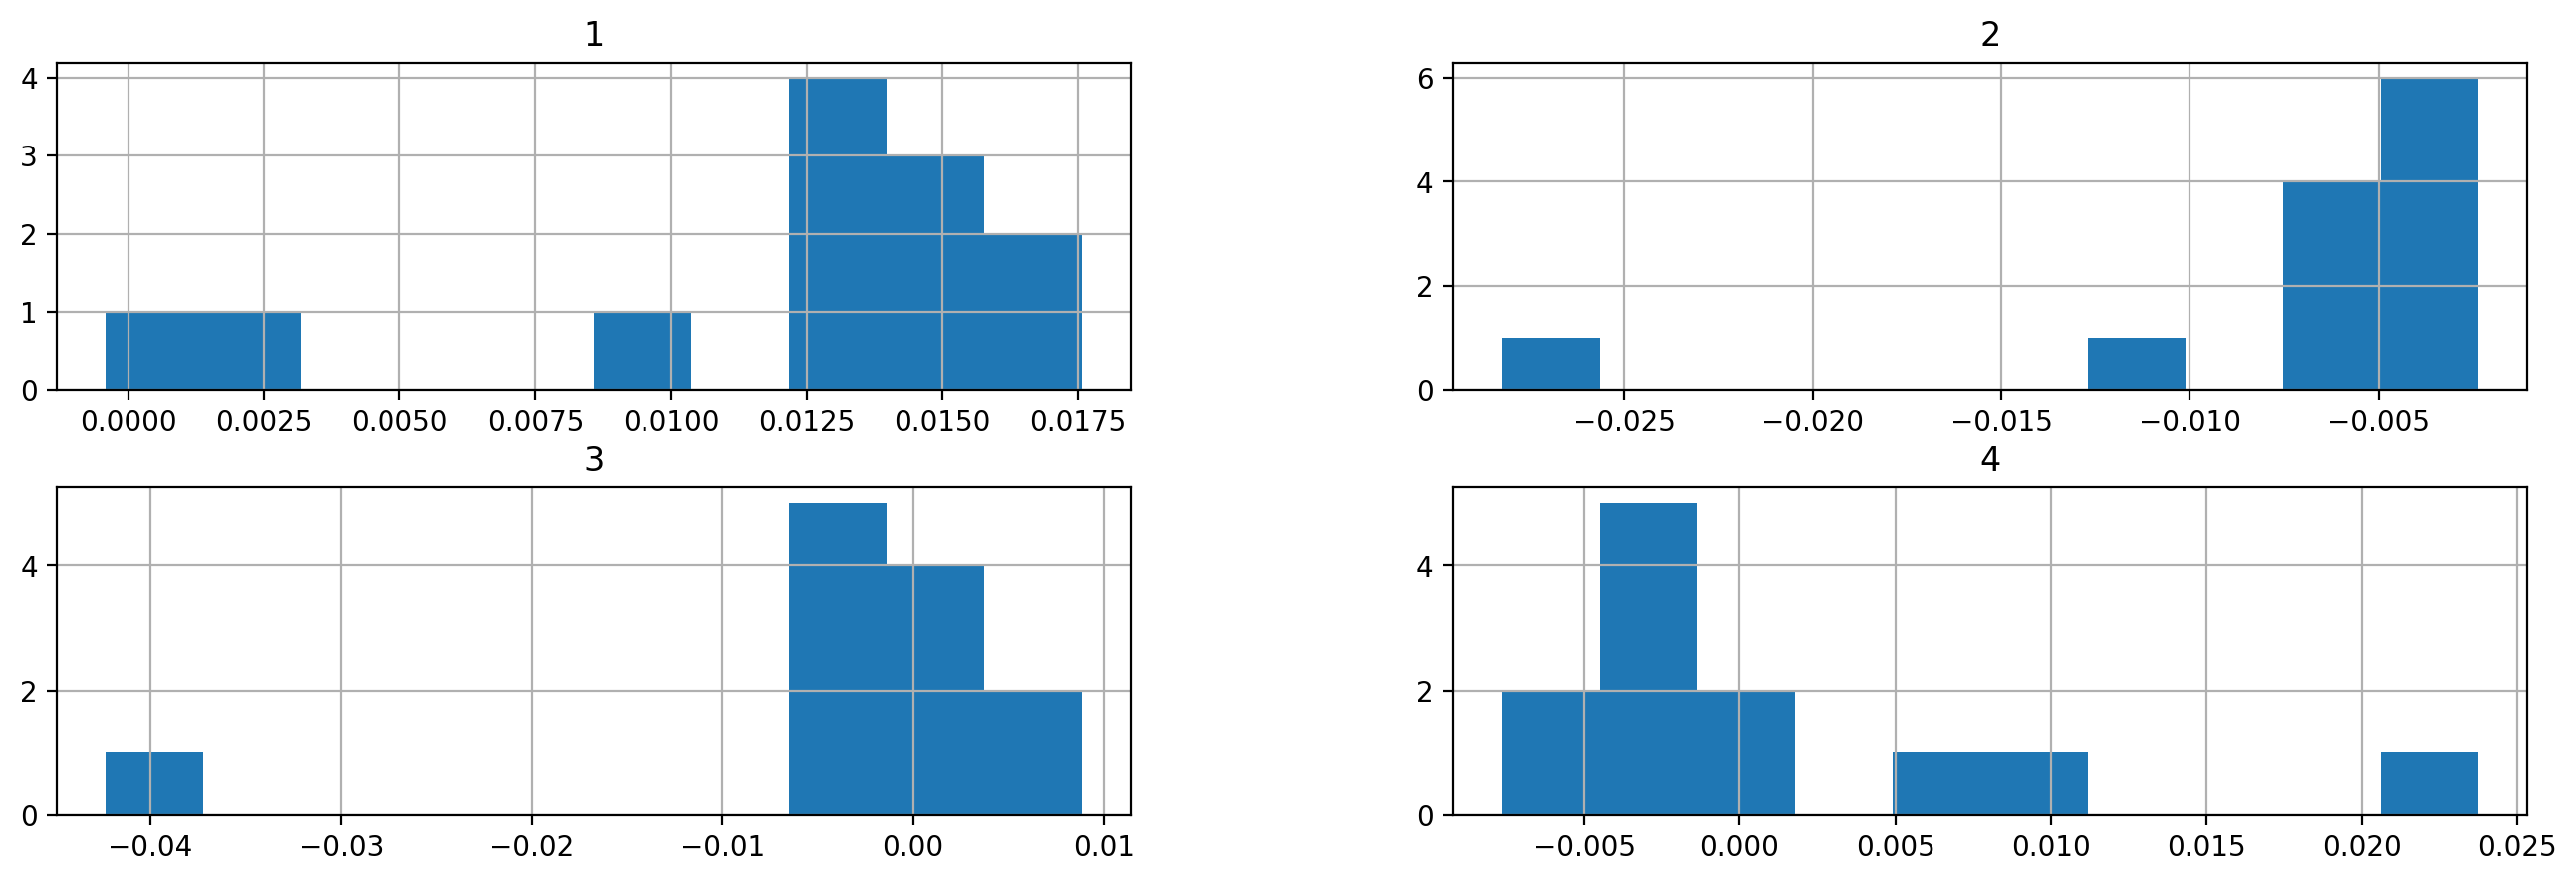

In [61]:
# Mo64 S126	12	1
public[public['formula'] == 'Mo64 S126'].iloc[:, -4:].hist();

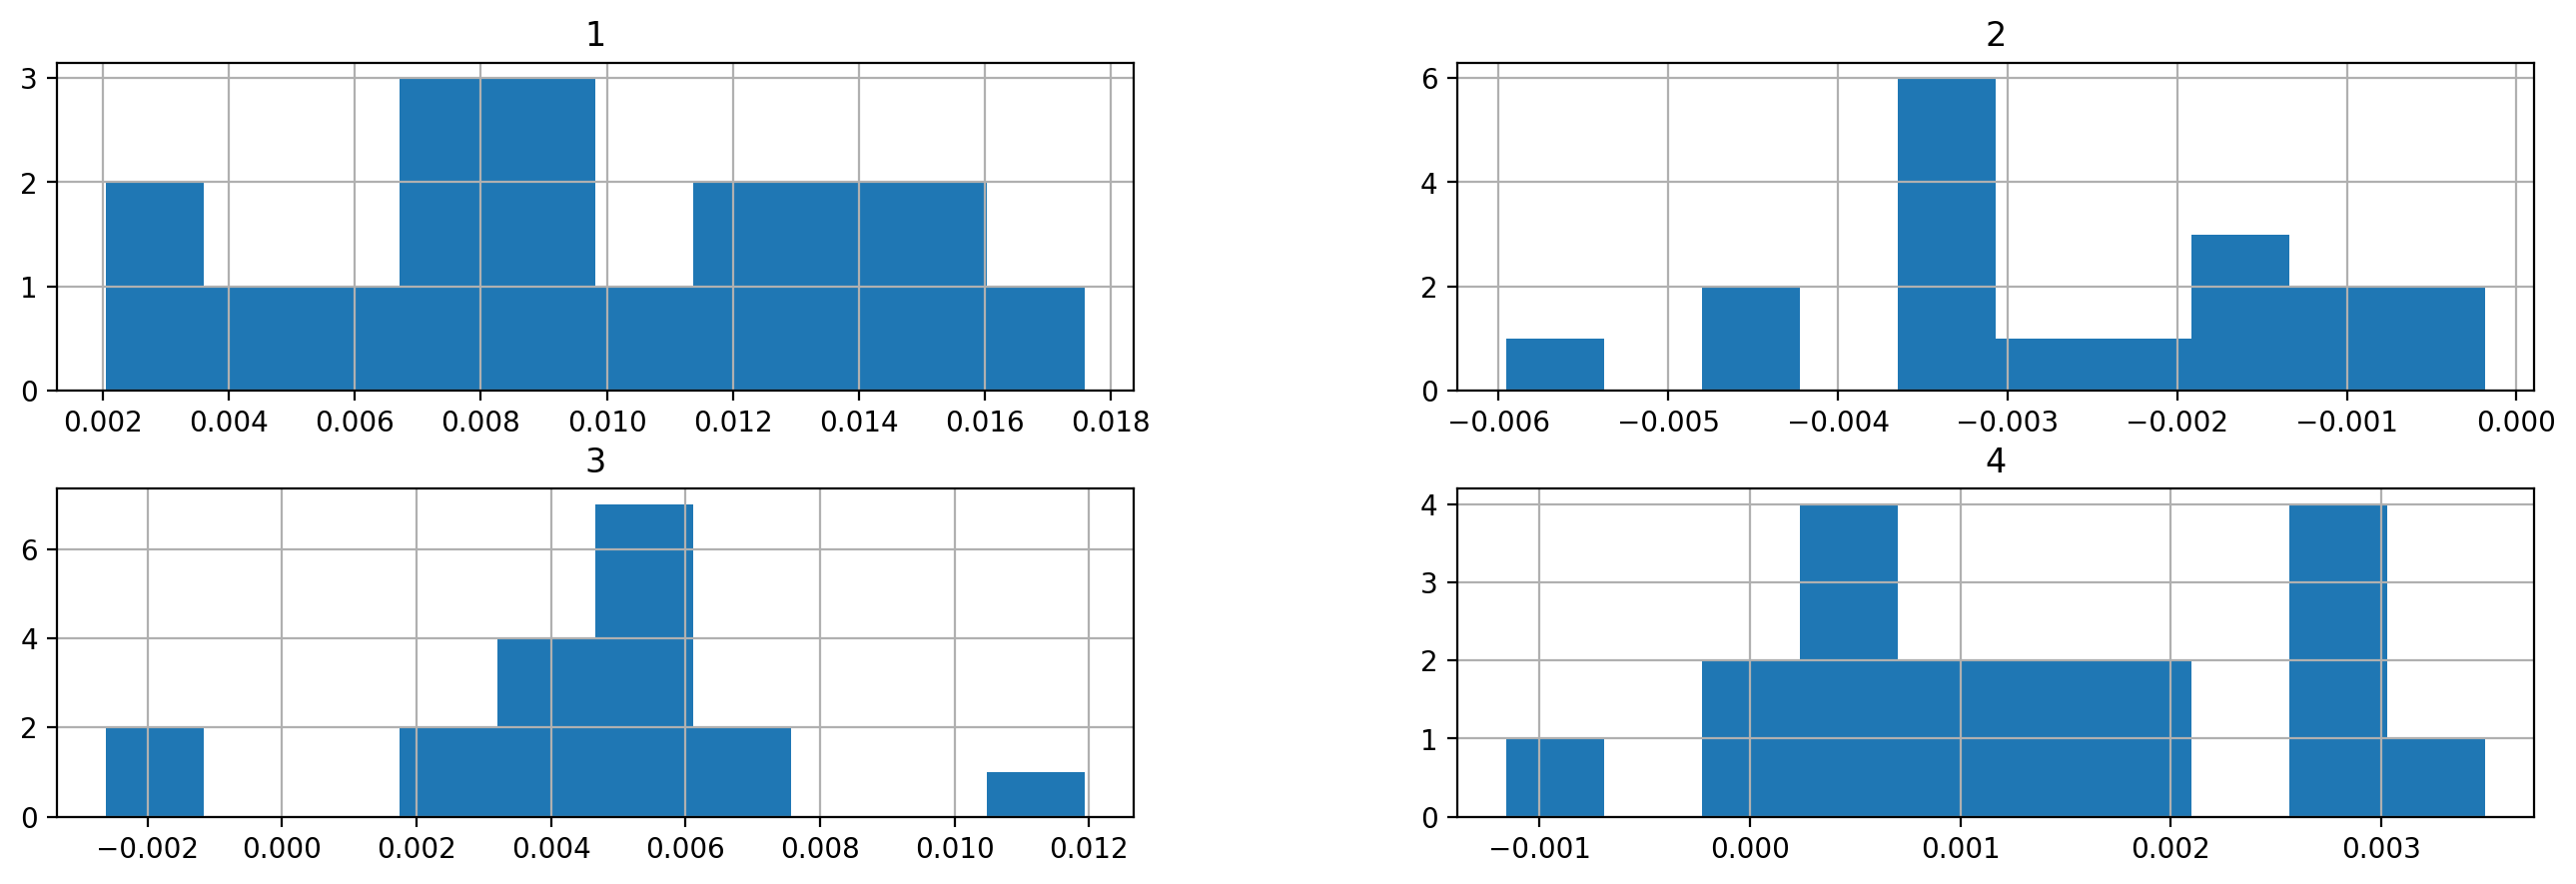

In [62]:
# Mo64 Se1 S126	18	0
public[public['formula'] == 'Mo64 Se1 S126'].iloc[:, -4:].hist();

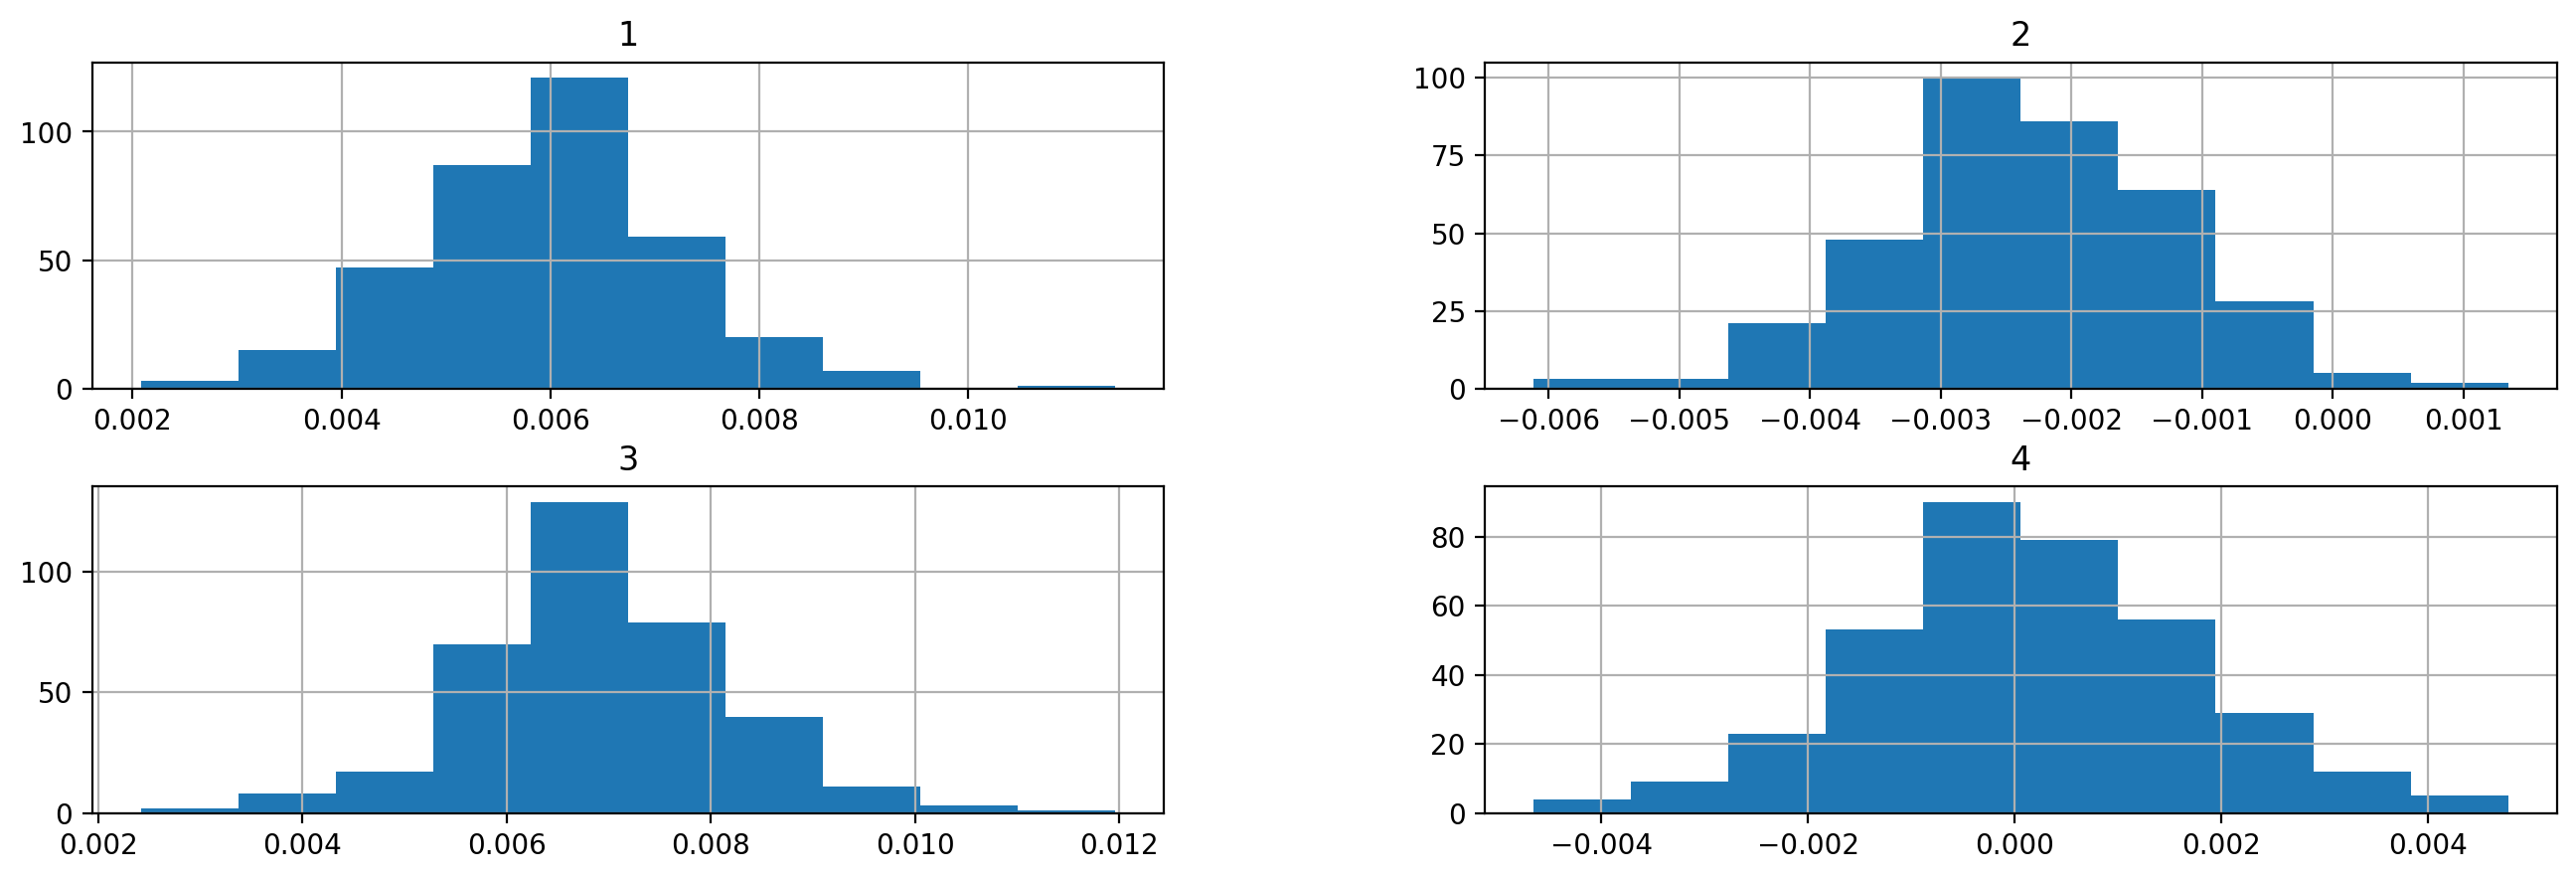

In [63]:
# Mo63 W1 Se2 S126	360	0
public[public['formula'] == 'Mo63 W1 Se2 S126'].iloc[:, -4:].hist();

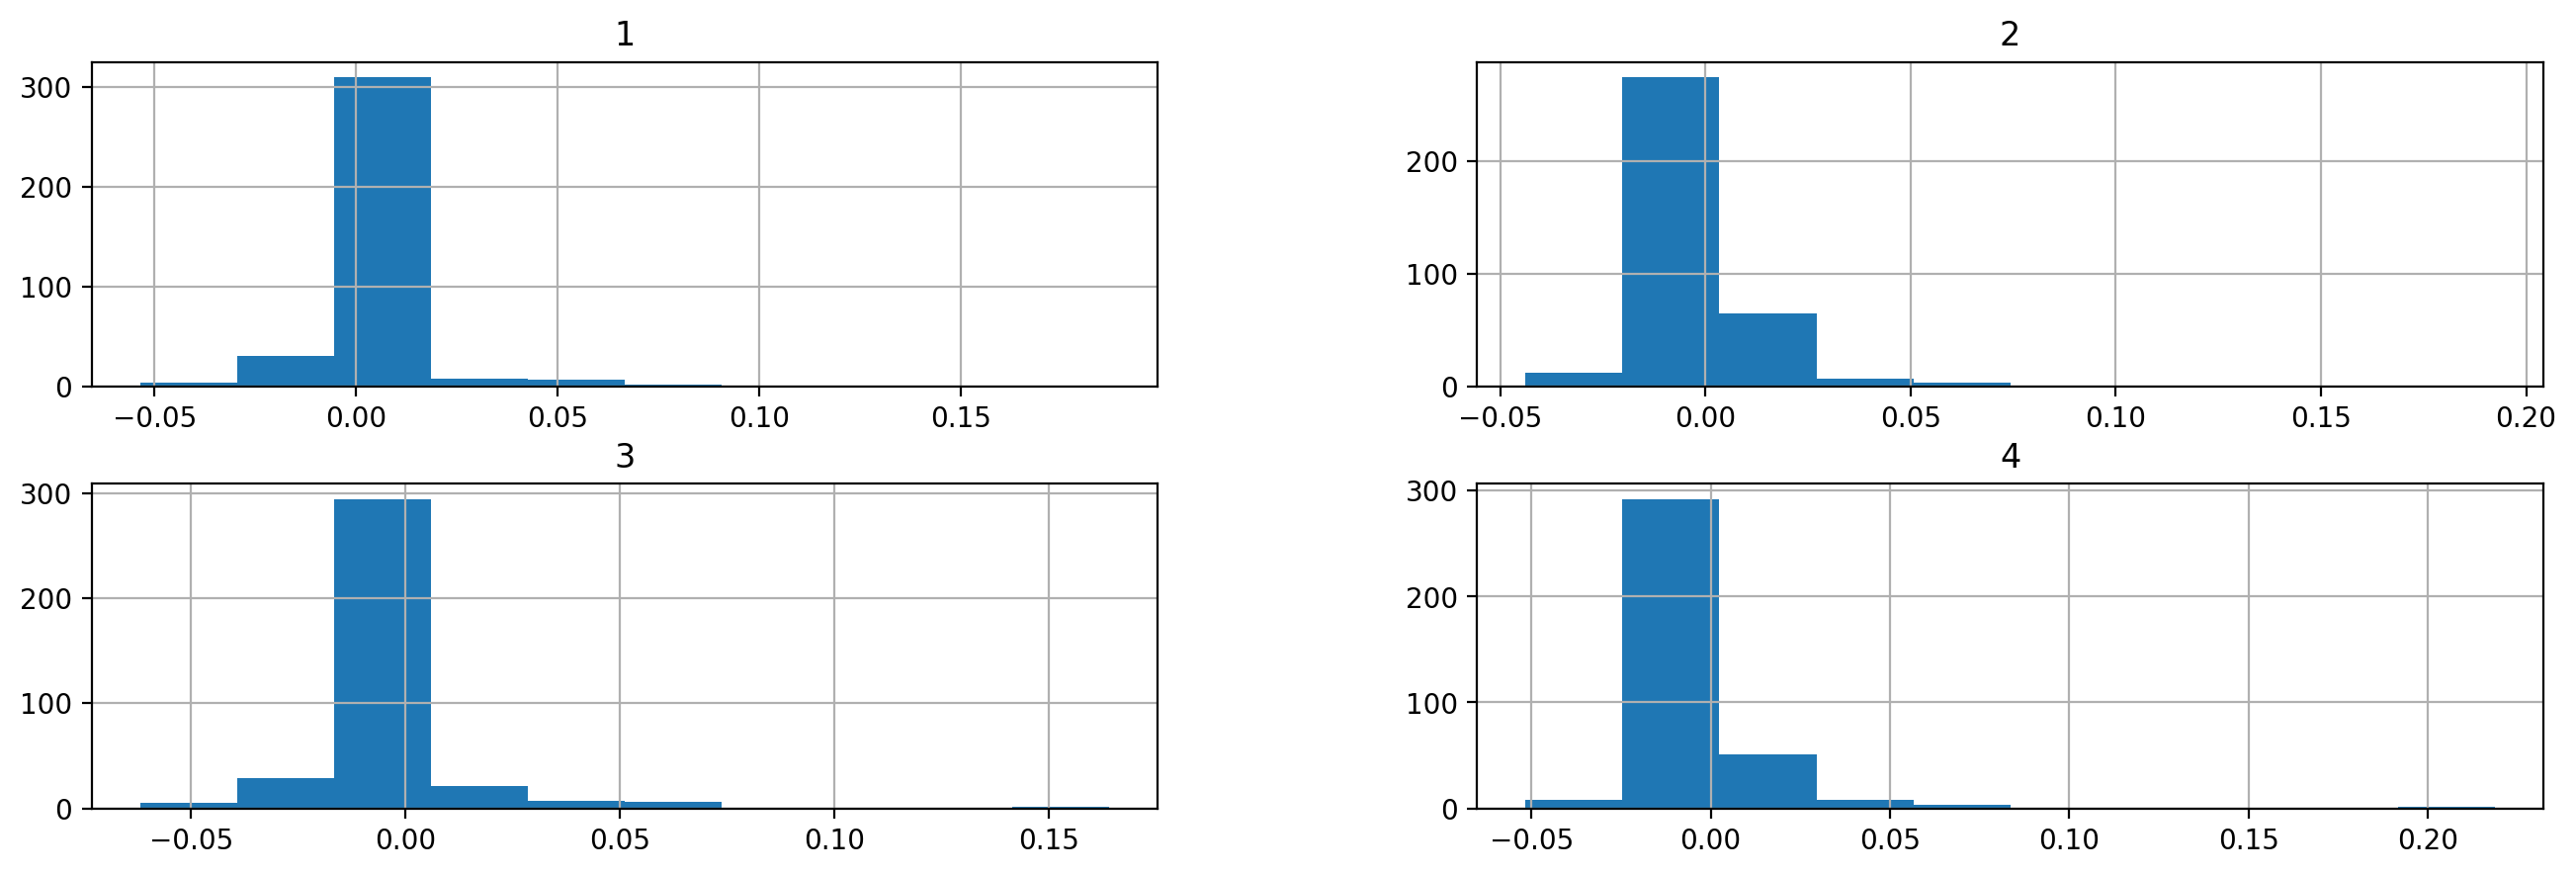

In [64]:
# Mo63 S126	363	40
public[public['formula'] == 'Mo63 S126'].iloc[:, -4:].hist();

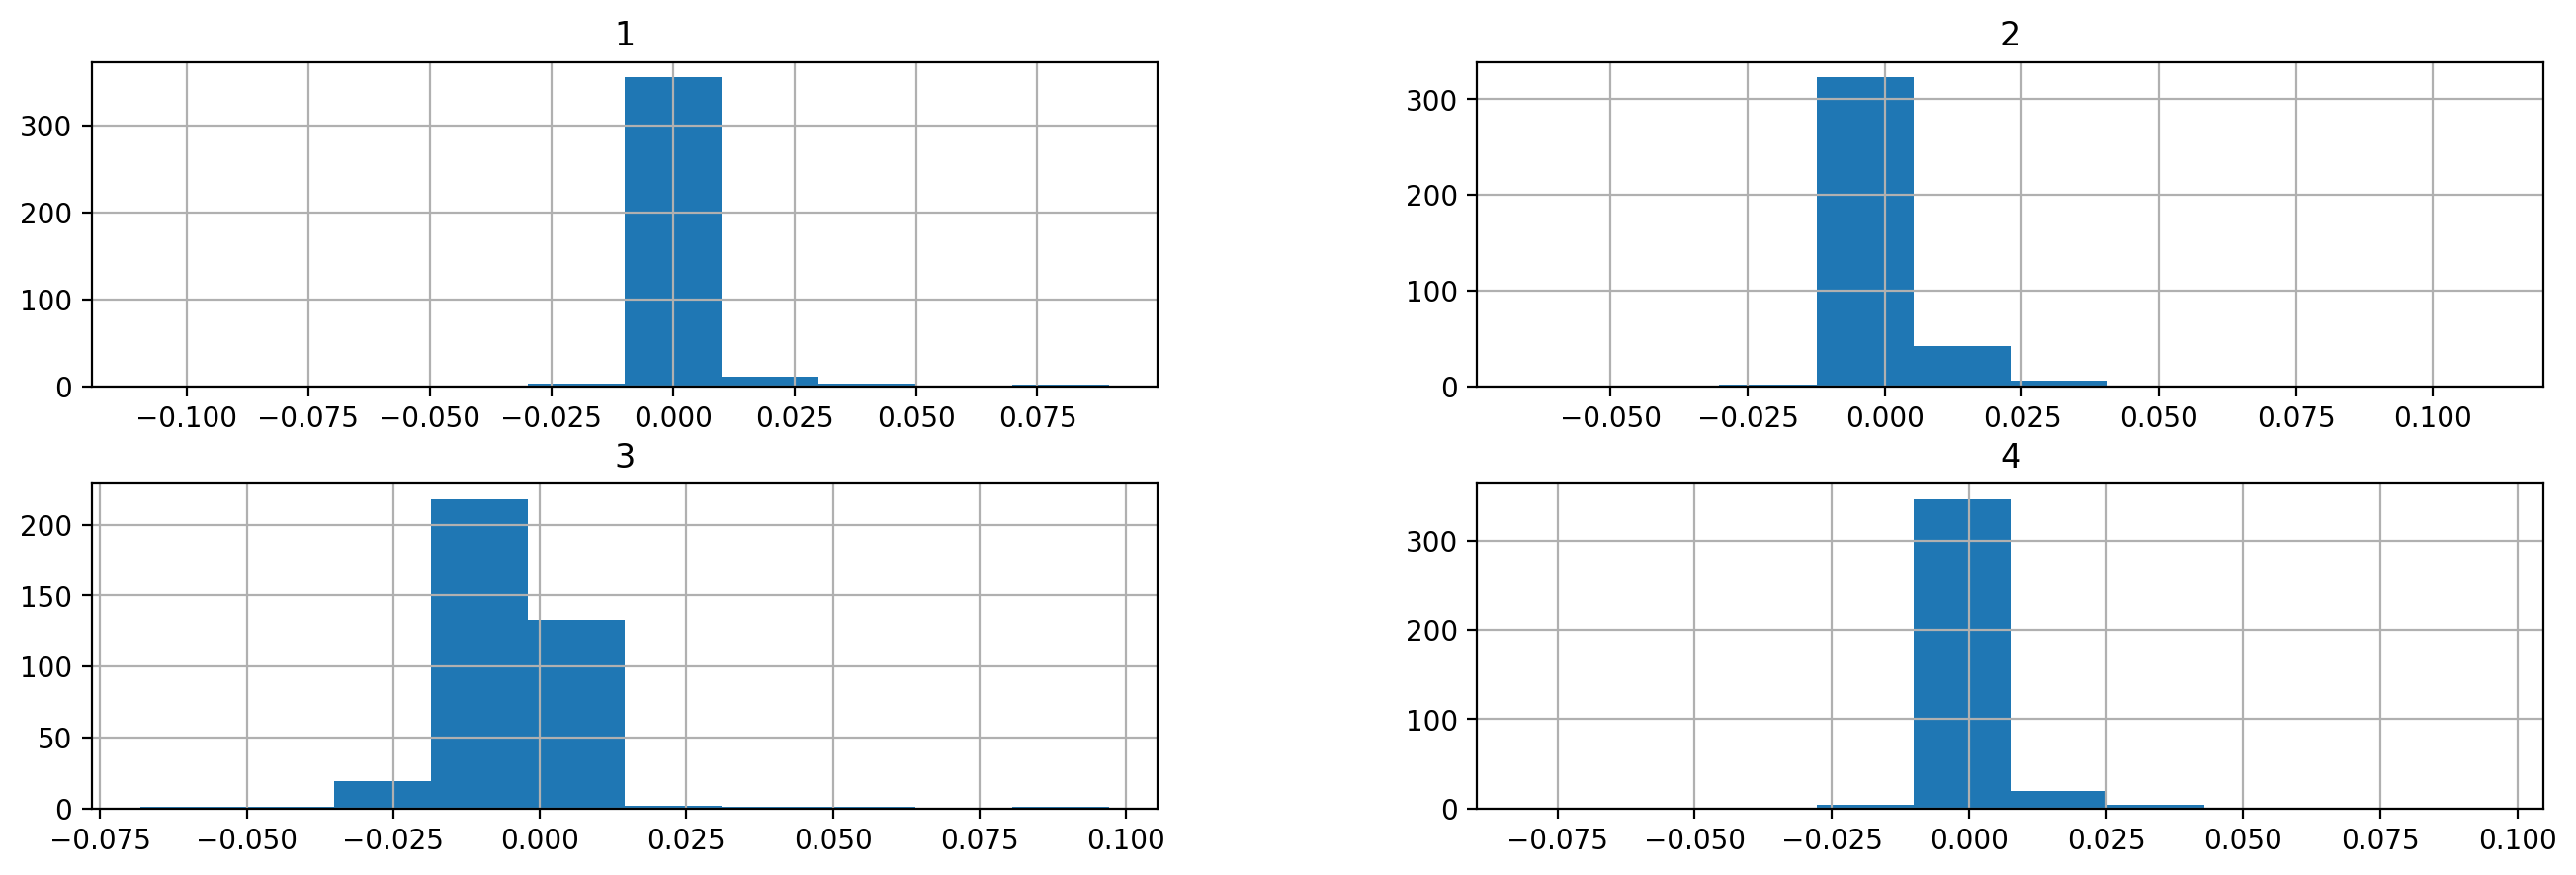

In [65]:
# Mo63 Se2 S126	377	29
public[public['formula'] == 'Mo63 Se2 S126'].iloc[:, -4:].hist();

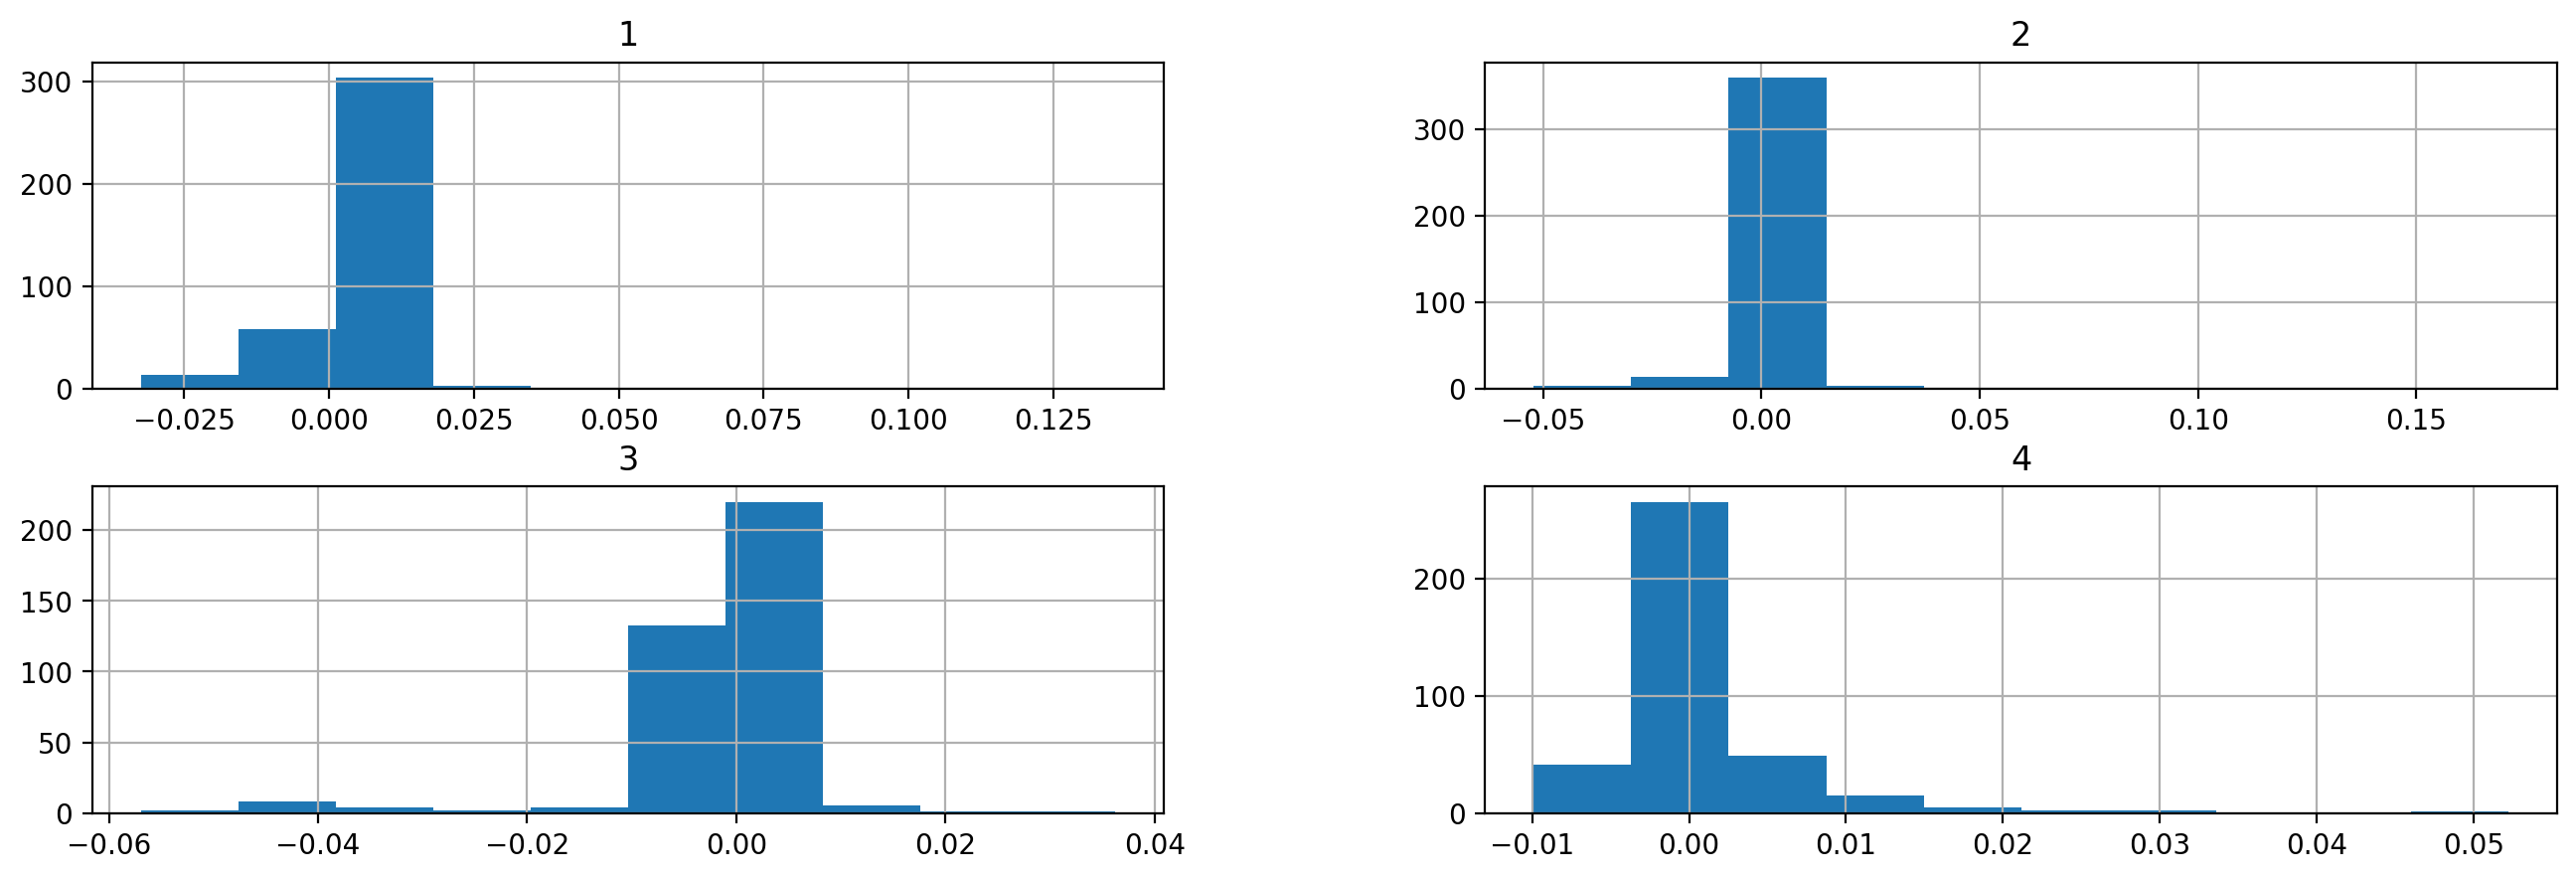

In [66]:
# Mo63 W1 S126	380	23
public[public['formula'] == 'Mo63 W1 S126'].iloc[:, -4:].hist();

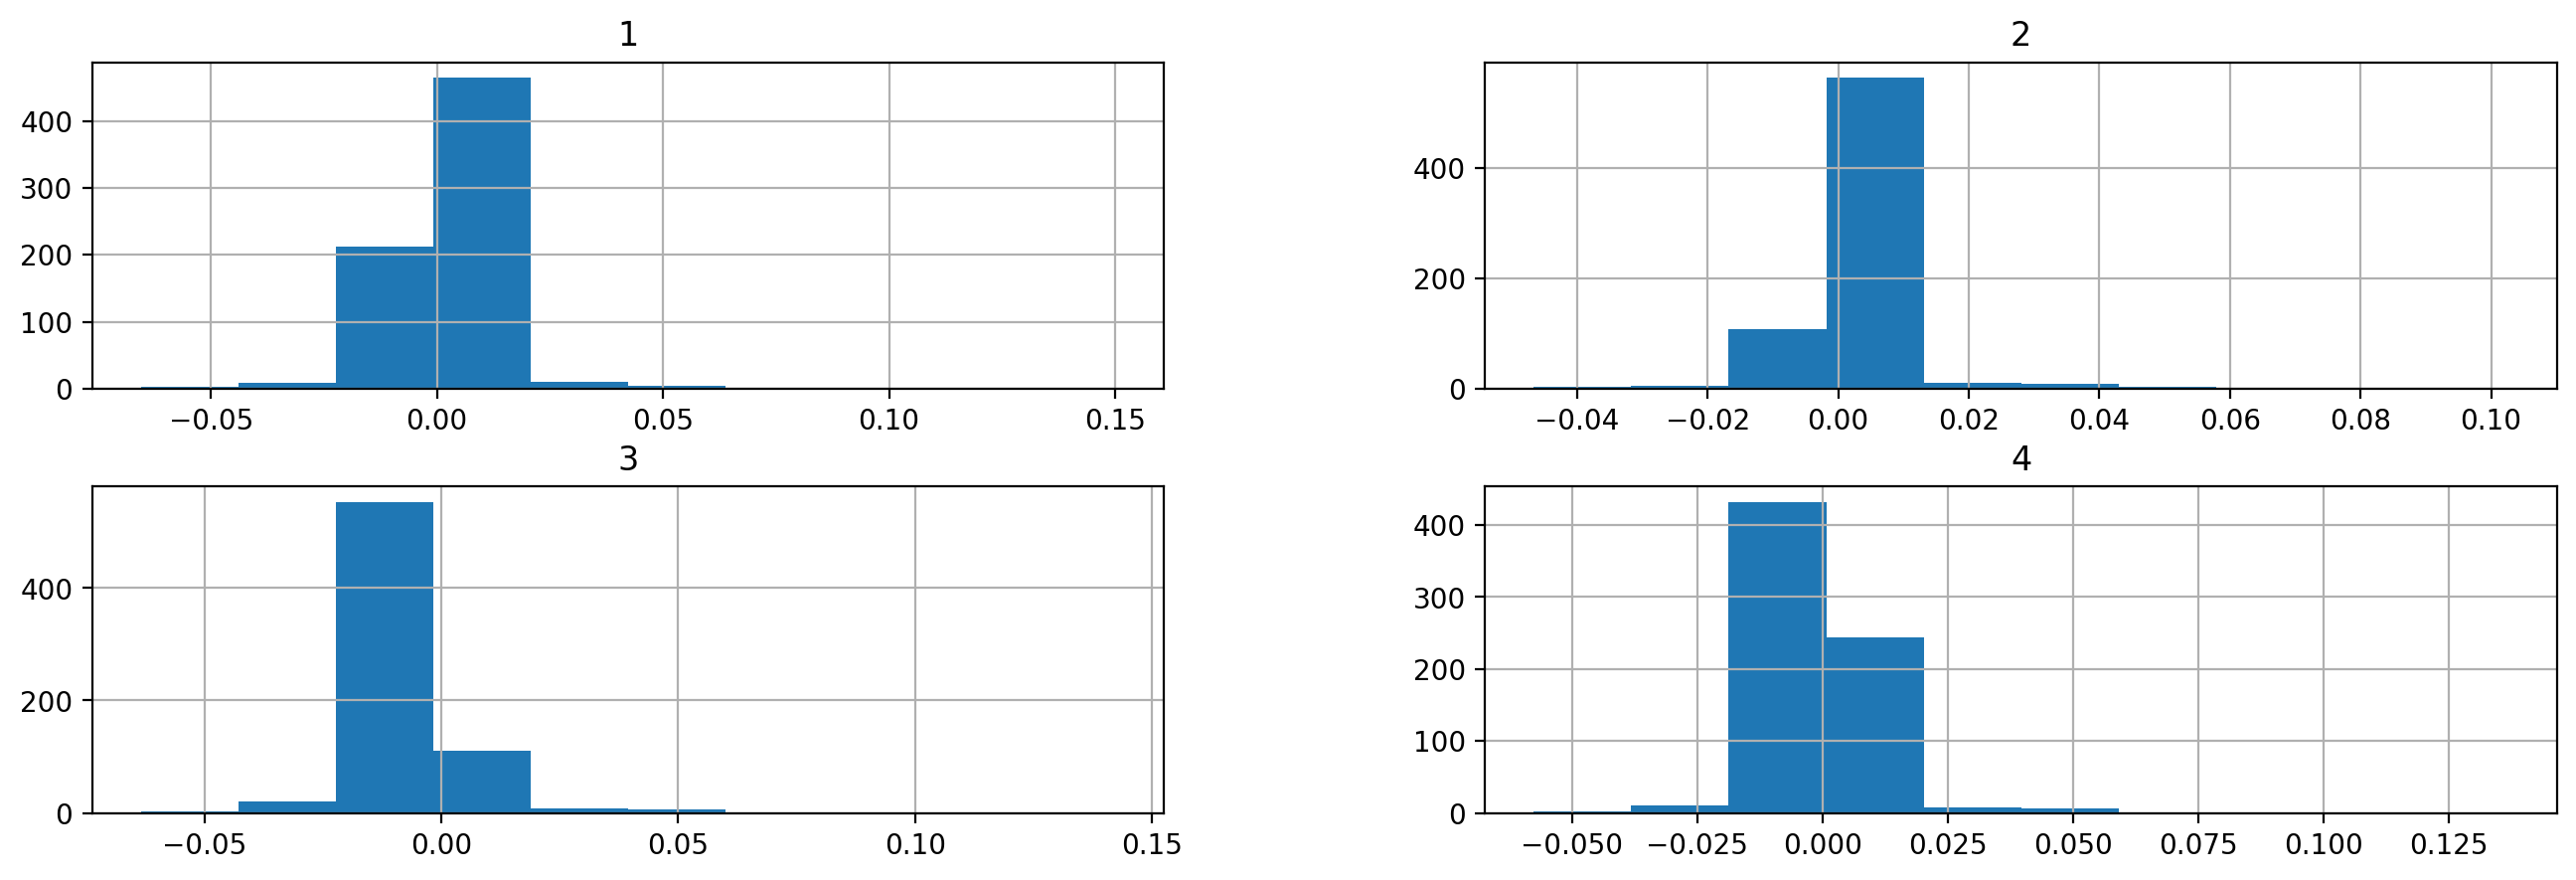

In [67]:
# Mo63 Se1 S126	702	58
public[public['formula'] == 'Mo63 Se1 S126'].iloc[:, -4:].hist();

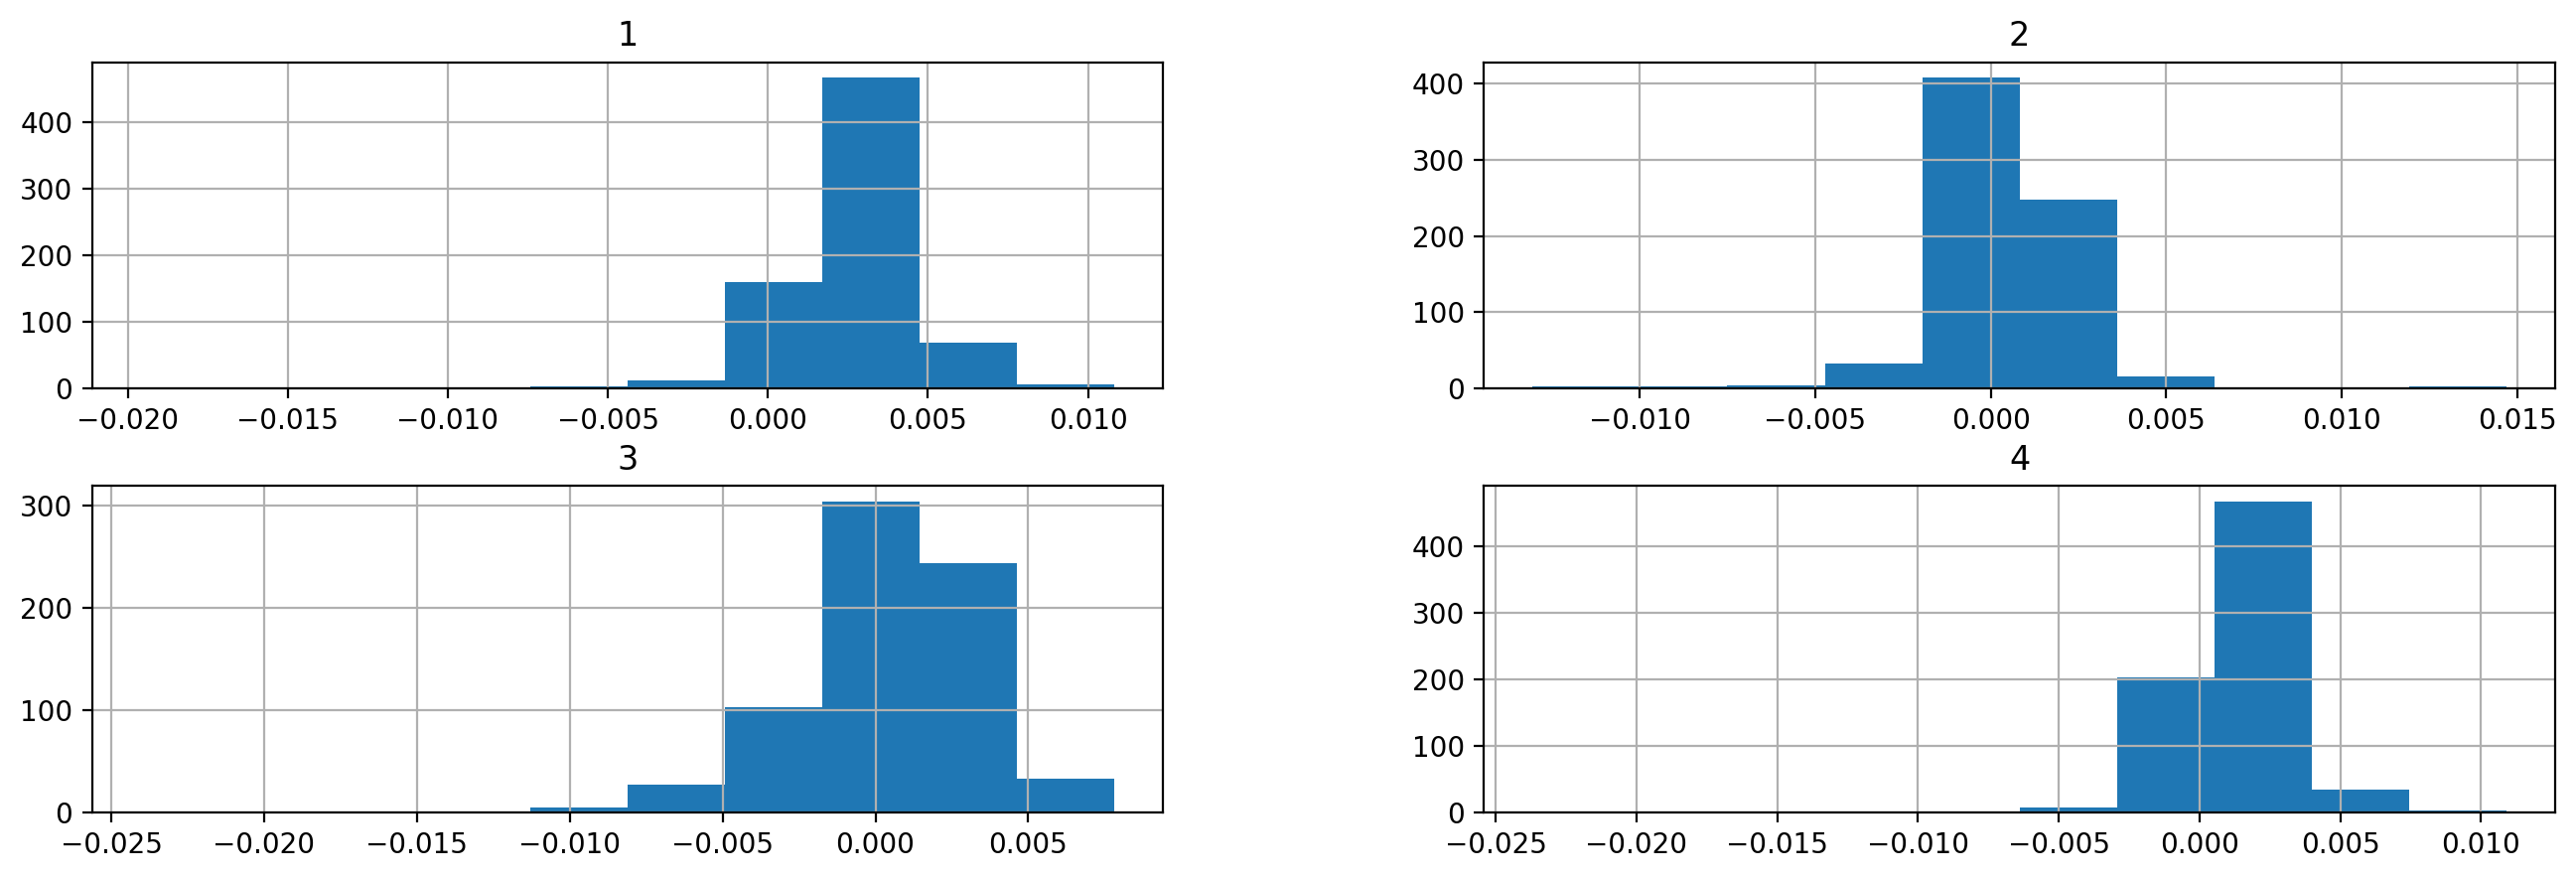

In [68]:
# Mo63 W1 Se1 S126	716	1
public[public['formula'] == 'Mo63 W1 Se1 S126'].iloc[:, -4:].hist();